In [1]:
import sys
import numpy as np
import scipy as sc
import scipy.linalg as la
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (8,10)
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objects as go
from scipy.optimize import minimize_scalar, minimize, shgo, basinhopping, differential_evolution, dual_annealing
#from scipy.misc import derivative
from matplotlib import cm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import FloatProgress
from IPython.display import display, HTML, clear_output
from IPython.display import Image, SVG
#import time
%matplotlib notebook
%load_ext tikzmagic
#https://github.com/mkrphys/ipython-tikzmagic
#
#https://github.com/mkrphys/ipython-tikzmagic/issues/18
#On Ubuntu 18.04, I ran into the same issue. It seems the problem was because ImageMagick tightened 
#their security policy so that it prevented the generation of PNG file from the PDF file generated by latex. 
#To fix this problem, I edited /etc/ImageMagick-6/policy.xml, changing the following
#
#<policy domain="coder" rights="none" pattern="PDF />
#
#to
#
#<policy domain="coder" rights="read|write" pattern="PDF />
#
#http://blog.invibe.net/posts/2015-01-20-using-tikzmagic.html
#https://stackoverflow.com/questions/45671481/how-do-i-center-the-outputs-on-a-python-jupyter-notebook
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
display(HTML("<style>.container { width:80% !important; }</style>"))
#print(sc.__version__)
#print(numpy.__version__)

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


# Comparison of Spin Spiral Approaches
# Hubbard Model on the Square Lattice with 1 Site Unit Cell

## Goal

- Compare two approaches for including spin spiral in the mean field describtion of the Hubbard Model
- Check if both approaches can be used in the Variational Approach
- Check if both approaches are capable to describe the same spin spiral states

## Lattice and Unit Cell
We focus in the square lattice and decouple with resoect to a 1-site unit cell.

In [2]:
%%tikz -f png -s 800,500 -sc 1.0
%\tikzset{>=stealth,font=\Large};

\fill [opacity=0.75,blue!80] (+1,+1) -- (+3,+1) -- (+3,+3) -- (+1,+3) -- cycle;

\draw [style=help lines, step=2] (-1,-1) grid (+5,+5);
 
\filldraw [color=gray]	(0,0) circle (.1);
\filldraw [color=gray]	(0,2) circle (.1);
\filldraw [color=gray]	(0,4) circle (.1);

\filldraw [color=gray]	(2,0) circle (.1);
\filldraw [color=black]	(2,2) circle (.1);
\filldraw [color=gray]	(2,4) circle (.1);

\filldraw [color=gray]	(4,0) circle (.1);
\filldraw [color=gray]	(4,2) circle (.1);
\filldraw [color=gray]	(4,4) circle (.1);

\draw ( 2, 1.9) node[anchor=north] {$(i,j)_{0}$};

This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/TeX Live for SUSE Linux) (preloaded format=pdflatex)
 \write18 enabled.
entering extended mode
(./tikz.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/share/texmf/tex/latex/standalone/standalone.cls
Document Class: standalone 2015/07/15 v1.2 Class to compile TeX sub-files stand
alone
(/usr/share/texmf/tex/generic/oberdiek/ifluatex.sty)
(/usr/share/texmf/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf/tex/generic/ifxetex/ifxetex.sty)
(/usr/share/texmf/tex/latex/xkeyval/xkeyval.sty
(/usr/share/texmf/tex/generic/xkeyval/xkeyval.tex
(/usr/share/texmf/tex/generic/xkeyval/xkvutils.tex
(/usr/share/texmf/tex/generic/xkeyval/keyval.tex))))
(/usr/share/texmf/tex/latex/standalone/standalone.cfg)
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))This is pdfTeX, Version 3.1415926

convert: not authorized `tikz.pdf' @ error/constitute.c/ReadImage/428.
convert: no images defined `tikz.png' @ error/convert.c/ConvertImageCommand/3275.
system returned with code 256
No image generated.


## Constants

### k-Grid

In [3]:
number_of_steps = 30
kx_grid = np.linspace(-np.pi, np.pi, number_of_steps, endpoint=True)
ky_grid = np.linspace(-np.pi, np.pi, number_of_steps, endpoint=True)

### Model parameters

In [4]:
Hubbard_U = 4.0
Q = np.array([np.pi,np.pi])
n = 1.0
m = 0.5
theta = np.pi
Chemical_Potential = 2.0

### Cut through 1. Brillouin Zone - Bandstructure

In [ ]:
%%tikz -f png -s 800,500 -sc 1.0
\tikzset{>=stealth,font=\Large};

\filldraw[fill=green!20!white, draw=black, dotted] (-pi,pi) rectangle (pi,-pi);

\draw[very thin, gray, step=.25*pi] (-1.0*pi,1.0*pi) grid (1.0*pi,-1.0*pi);
\draw[color=black, thick, solid,->] (-1.5*pi,0.0) -- (1.5*pi,0.0);
\draw[color=black, thick, solid,->] (0.0,-1.5*pi) -- (0.0,1.5*pi);

\draw[anchor=north east] (0.0,0.0) node {$\Gamma$};
\draw[anchor=north] (pi,0.0) node {$X$};
\draw[anchor=south west] (pi,pi) node {$M$};

\draw[color=blue, very thick, solid] (0.0,0.0) -- (1.0*pi,0.0);
\draw[color=blue, very thick, solid] (1.0*pi,0.0) -- (1.0*pi,pi);
\draw[color=blue, very thick, solid] (1.0*pi,pi) -- (0.0,0.0);

%\draw[anchor=north] (1.0,0.0) node {$\frac{1}{2}$};
%\draw[anchor=north] (0.0,0.0) node {$0$};
%\draw[anchor=east] (0.0,3.5) node {$2$};


In [5]:
path_1_kx = np.linspace(0.0, np.pi, number_of_steps, endpoint=True)
path_3_kx = np.linspace(np.pi, 0.0, number_of_steps, endpoint=True)
path_1 = np.ndarray((number_of_steps,2), dtype=float)
path_2 = np.ndarray((number_of_steps,2), dtype=float)
path_3 = np.ndarray((number_of_steps,2), dtype=float)

for ikx, kx in enumerate(path_1_kx):
    path_1[ikx][0] = kx
    path_1[ikx][1] = 0.0

for iky, ky in enumerate(path_1_kx):
    path_2[iky][0] = np.pi
    path_2[iky][1] = ky

for ikx, kx in enumerate(path_3_kx):
    path_3[ikx][0] = kx
    path_3[ikx][1] = kx

# The Bloch Sphere Parametrization Appraoch

## Model
$$\newcommand{\OP}[1]{\hat{#1}}$$
$$\newcommand{\vectr}[1]{\boldsymbol{#1}}$$

The Hubbard model Hamiltonian for a n-site unit cell with site index $\alpha$ reads:

\begin{equation}
\OP{H} = \underbrace{\sum_{i,j}\sum_{\alpha,\beta}\sum_{\sigma} t^{\phantom{\dagger}}_{(i,\alpha),(j,\beta)} \hat{c}^{\dagger}_{i,\alpha,\sigma} \hat{c}^{\phantom{\dagger}}_{j,\beta,\sigma}}_{=: \OP{H}_0}
 + \underbrace{U \sum_{i,\alpha}\hat{n}^{\phantom{\dagger}}_{i,\alpha,\uparrow}\hat{n}^{\phantom{\dagger}}_{i,\alpha,\downarrow}}_{=: \OP{H}_\mathrm{I}}
\end{equation}

with $\hat{n}^{\phantom{\dagger}}_{i,\alpha,\sigma} =  \hat{c}^{\dagger}_{i,\alpha,\sigma} \hat{c}^{\phantom{\dagger}}_{i,\alpha,\sigma}$. The integer index set $\{i,j\}$ labels the respective cells originating from shifting the unit cell (UC) by integral multiples of the translation vectors and $\{\alpha,\alpha'\}$ the respective site index within the cell. The number of cells will be labeled $N_{\mathrm{UC}}$ and the number of basis sites $N_{\mathrm{B}}$.

### Hopping


The Fourier transformation of the general hoping term $\OP{H}_0$ reads:

\begin{equation}
 \OP{H}_0 = \sum_{\vectr{k}}\sum_{\alpha,\beta}\sum_{\sigma} \hat{c}^{\dagger}_{\vectr{k},\alpha,\sigma} \hat{c}^{\phantom{\dagger}}_{\vectr{k},\beta,\sigma} \underbrace{\left( \sum_{\vectr{\eta}_j} t^{\phantom{\dagger}}_{\alpha,\beta} e^{i\vectr{k}\cdot\vectr{\eta}_j} \right)}_{=: t_{\alpha,\beta}(\vectr{k})}.
\end{equation}

with

\begin{equation}
t_{\alpha,\beta}(\vectr{k}) = \sum_{\vectr{\eta}_j} t^{\alpha,\beta}_{\vectr{\eta}_j} e^{i\vectr{k}\cdot\vectr{\eta}_j}
\end{equation}

In [6]:
def Hopping_1SUC_Blochparametrization(k):
        t = -1.0
        Translations = np.array([[1.0,0.0],[-1.0,0.0],[0.0,1.0],[0.0,-1.0]])
        hopping_amplitude = 0.0+0.0j
        for Tvec in Translations:
            hopping_amplitude += t*np.exp((Tvec[0]*k[0]+Tvec[1]*k[1])*1.0j)
        return hopping_amplitude

### The Trial Hamiltonian

\begin{equation}
\begin{split}
\OP{H}^{\mathrm{HF}} 
= \sum_{\vectr{k}}\sum_{\alpha,\alpha'}
&\left(\hat{c}^{\dagger}_{\vectr{k},\alpha,\uparrow} 
\mathcal{H}^{\uparrow\uparrow}_{\alpha,\alpha'} \left(\vectr{k}\right)\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k},\alpha',\uparrow}
%
+\hat{c}^{\dagger}_{\vectr{k},\alpha,\uparrow} 
\mathcal{H}^{\uparrow\downarrow}_{\alpha,\alpha'}\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k} + \vectr{q},\alpha',\downarrow}\right.\\
%
+&\left.\hat{c}^{\dagger}_{\vectr{k}+\vectr{q},\alpha,\downarrow} 
\mathcal{H}^{\downarrow\uparrow}_{\alpha,\alpha'}\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k},\alpha',\uparrow}
%
+\hat{c}^{\dagger}_{\vectr{k}+\vectr{q},\alpha,\downarrow}
\mathcal{H}^{\downarrow\downarrow}_{\alpha,\alpha'} \left(\vectr{k}+\vectr{q}\right)\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k} + \vectr{q},\alpha',\downarrow}\right)
%
\end{split}
\end{equation}

with the matrix elements for spin and charge decoupling read:

\begin{align}
\mathcal{H}^{\uparrow\uparrow}_{\alpha,\alpha'} \left(\vectr{k}\right) &= 
t_{\alpha,\alpha'}\left(\vectr{k}\right)
+ \delta_{\alpha,\alpha'}\left[U\left( \frac{\varrho^{\phantom{\dagger}}_{\alpha}}{2} - m_{\alpha} \cos{(\theta_{\alpha})} \right) \right]\\
%
\mathcal{H}^{\uparrow\downarrow}_{\alpha,\alpha'} = \mathcal{H}^{\downarrow\uparrow}_{\alpha,\alpha'} &=
\delta_{\alpha,\alpha'} \left[ -U m_{\alpha} \sin{(\theta_{\alpha})}\right]\\
%
\mathcal{H}^{\downarrow\downarrow}_{\alpha,\alpha'} \left(\vectr{k}+\vectr{q}\right) &= 
t_{\alpha,\alpha'}\left(\vectr{k}+\vectr{q}\right)
+ \delta_{\alpha,\alpha'}\left[U\left( \frac{\varrho^{\phantom{\dagger}}_{\alpha}}{2} + m_{\alpha} \cos{(\theta_{\alpha})} \right) \right]
\end{align}

Indexing Matrix elements

\begin{equation}
 a = 2(\alpha - 1) + \sigma
\end{equation}

with spin index $\sigma\in\{0 (\uparrow),1 (\downarrow)\}$ and site index $\alpha\in\{1,2,\dots,N_B\}$

In [7]:
def Hamiltonian_UC_1S_Blochparametrization(k,Q,n,m,theta):
    """"Returns np.array like Matrix"""
    
    A = np.zeros((2, 2), dtype=complex)
    
    A[0][0] = Hopping_1SUC_Blochparametrization(k)
    A[0][0] += 0.5*Hubbard_U*n-Hubbard_U*m*np.cos(theta) + 0j
        
    A[0][1] = -Hubbard_U*m*np.sin(theta) + 0j
    
    A[1][0] = -Hubbard_U*m*np.sin(theta) + 0j
    
    A[1][1] = Hopping_1SUC_Blochparametrization(k+Q)
    A[1][1] += 0.5*Hubbard_U*n+Hubbard_U*m*np.cos(theta) + 0j
    
    return A

In [ ]:
#Hubbard_U = 4.0
#Hamiltonian_UC_1S(np.array([0.0,0.0]),np.array([0.0,0.0]),0.0,0.0,0.0)

## Bandstructure Plots

In [8]:
def Set_Spectrum_Bands_UC_1S_Blochparametrization(q,n,m,theta):
    global kx_grid
    global ky_grid
    
    Band_1 = np.zeros((1,number_of_steps))
    tempBand_1 = np.zeros(number_of_steps)

    Band_2 = np.zeros((1,number_of_steps))
    tempBand_2 = np.zeros(number_of_steps)
     
    for ky in ky_grid:
        for idx, kx in enumerate(kx_grid):
            w, v = la.eigh(Hamiltonian_UC_1S_Blochparametrization(np.array([kx,ky]),q,n,m,theta))
            tempBand_1[idx] = w[0]
            tempBand_2[idx] = w[1]
        Band_1 = np.concatenate((Band_1,[tempBand_1]), axis=0)
        Band_2 = np.concatenate((Band_2,[tempBand_2]), axis=0)
    
    Band_1 = np.delete(Band_1, 0, 0)
    Band_2 = np.delete(Band_2, 0, 0)
    return Band_1, Band_2

def Set_Spectrum_Bands_UC_1S_evecs_Blochparametrization(q,n,m,theta):
    global kx_grid
    global ky_grid
    
    Band_1 = np.zeros((1,number_of_steps))
    tempBand_1 = np.zeros(number_of_steps)

    Band_2 = np.zeros((1,number_of_steps))
    tempBand_2 = np.zeros(number_of_steps)
    
    Band_1_evecs = np.zeros((1,number_of_steps,2),dtype=complex)
    tempBand_1_evecs = np.zeros((1,2),dtype=complex)
    
    Band_2_evecs = np.zeros((1,number_of_steps,2),dtype=complex)
    tempBand_2_evecs = np.zeros((1,2),dtype=complex)
    
    for ky in ky_grid:
        tempBand_1_evecs = np.zeros((1,2),dtype=complex)
        tempBand_2_evecs = np.zeros((1,2),dtype=complex)
        for idx, kx in enumerate(kx_grid):
            w, v = la.eigh(Hamiltonian_UC_1S_Blochparametrization(np.array([kx,ky]),q,n,m,theta))
            tempBand_1[idx] = w[0]
            tempBand_2[idx] = w[1]
            tempBand_1_evecs = np.concatenate((tempBand_1_evecs,[v[0]]), axis=0)
            tempBand_2_evecs = np.concatenate((tempBand_2_evecs,[v[1]]), axis=0)
        Band_1 = np.concatenate((Band_1,[tempBand_1]), axis=0)
        Band_2 = np.concatenate((Band_2,[tempBand_2]), axis=0)
        
        tempBand_1_evecs = np.delete(tempBand_1_evecs, 0, 0)        
        tempBand_2_evecs = np.delete(tempBand_2_evecs, 0, 0)
        Band_1_evecs = np.concatenate((Band_1_evecs,[tempBand_1_evecs]), axis=0)
        Band_2_evecs = np.concatenate((Band_2_evecs,[tempBand_2_evecs]), axis=0)
            
    Band_1 = np.delete(Band_1, 0, 0)
    Band_2 = np.delete(Band_2, 0, 0)
    Band_1_evecs = np.delete(Band_1_evecs, 0, 0)
    Band_2_evecs = np.delete(Band_2_evecs, 0, 0)
    return Band_1, Band_1_evecs, Band_2, Band_2_evecs

def get_Bands_UC_1S_Blochparametrization(k,q,n,m,theta):
    w, v = la.eigh(Hamiltonian_UC_1S_Blochparametrization(k,q,n,m,theta))
    return w

def Set_Spectrum_Band_i_UC_1S_Blochparametrization(i,q,n,m,theta):
    Band = np.zeros((1,number_of_steps))
    tempBand = np.zeros(number_of_steps)
    
    for ky in ky_grid:
        for idx, kx in enumerate(kx_grid):
            w, v = la.eigh(Hamiltonian_UC_1S_Blochparametrization(np.array([kx,ky]),q,n,m,theta))
            tempBand[idx] = w[i]
        Band = np.concatenate((Band,[tempBand]), axis=0)
    
    Band = np.delete(Band, 0, 0)

    return Band_1

In [9]:
Hubbard_U = 4.0
Q = np.array([np.pi,np.pi])
n = 1.0
m = 0.25
theta = np.pi
Chemical_Potential = 2.0

<IPython.core.display.Javascript object>


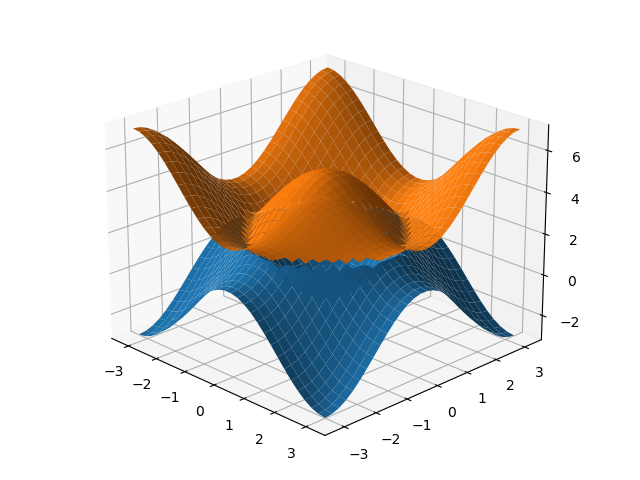

/tmp/ipykernel_18424/1822942725.py:19: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax1 = Axes3D(fig_bandstructure)


In [10]:
Band_1, Band_2 = Set_Spectrum_Bands_UC_1S_Blochparametrization(Q,n,m,theta)

# bandstructure along paths 1, 2, and 3
bandstructure_path_1 = np.ndarray((number_of_steps,2), dtype=float)
bandstructure_path_2 = np.ndarray((number_of_steps,2), dtype=float)
bandstructure_path_3 = np.ndarray((number_of_steps,2), dtype=float)

for idk,k in enumerate(path_1):
    bandstructure_path_1[idk] = get_Bands_UC_1S_Blochparametrization(k,Q,n,m,theta)

for idk,k in enumerate(path_2):
    bandstructure_path_2[idk] = get_Bands_UC_1S_Blochparametrization(k,Q,n,m,theta)

for idk,k in enumerate(path_3):
    bandstructure_path_3[idk] = get_Bands_UC_1S_Blochparametrization(k,Q,n,m,theta)


fig_bandstructure = plt.figure()
ax1 = Axes3D(fig_bandstructure)
kx, ky = np.meshgrid(kx_grid, ky_grid)
surf = ax1.plot_surface(kx, ky, Band_1, rstride=1, cstride=1)
surf = ax1.plot_surface(kx, ky, Band_2, rstride=1, cstride=1)
plt.show()

<IPython.core.display.Javascript object>


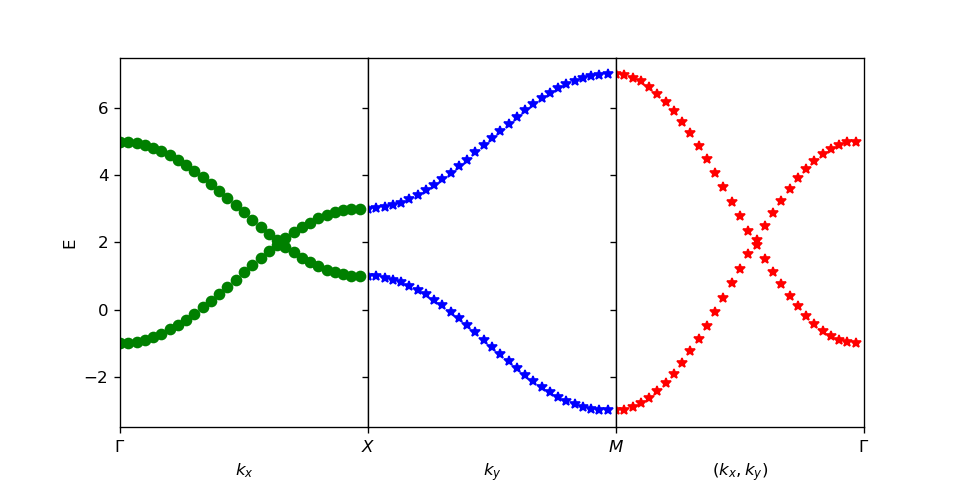

In [11]:
# Create Figure and Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4), sharey=True, dpi=120)
fig.subplots_adjust(wspace=0)


# Plot
ax1.plot(bandstructure_path_1, 'go')  # greendots
ax2.plot(bandstructure_path_2, 'b*')  # bluestart
ax3.plot(bandstructure_path_3, 'r*')  # bluestart

# Title, X and Y labels, X and Y Lim
#ax1.set_title('Scatterplot Greendots')
#ax2.set_title('Scatterplot Bluestars')
ax1.set_ylabel('E')
ax1.set_xlabel('$k_x$')
ax1.set_xlim(0,number_of_steps)
ax1.set_xticks([0.0,number_of_steps])
ax1.set_xticklabels(['$\Gamma$','$X$'])

ax2.set_xlabel('$k_y$')
ax2.set_xlim(0,number_of_steps)
ax2.set_xticks([number_of_steps])
ax2.set_xticklabels(['$M$'])

ax3.set_xlabel('$(k_x,k_y)$')
ax3.set_xlim(0,number_of_steps)
ax3.set_xticks([number_of_steps])
ax3.set_xticklabels(['$\Gamma$'])

plt.show()

## The Grand Canonical Functional

$\newcommand{\cOP}[1]{{\hat{#1}^{\dagger}}}$
$\newcommand{\aOP}[1]{{\hat{#1}^{\phantom{\dagger}}}}$

$\newcommand{\EW}[1]{\left<{#1}\right>}$
$\DeclareMathOperator{\Tr}{Tr}$

\begin{equation*}
\Phi\left[\OP{\rho}_{\mathrm{eff}}\right] =
\EW{\OP{H}}_{\mathrm{eff}} - \EW{\OP{H}_{\mathrm{eff}}}_{\mathrm{eff}} + \Phi_{\mathrm{eff}} 
\geq \Phi\left[ \OP{\rho}_{\mathrm{GK}} \right] = \Omega(T,\mu)
\end{equation*}

with the standard grand potential for the effective density operator:

\begin{equation*}
 \Phi_{\mathrm{eff}} = -k_BT \ln{\left(Z_{\mathrm{eff}}\right)} = -k_BT \ln{\left(\Tr\left\{e^{-\beta\left(\OP{H}_{\mathrm{eff}}-\mu\OP{N}\right)} \right\}\right)}.
\end{equation*}

We choose a proper trial hamiltonian, which is the Hartree Fock decoupled one of the previous section here. This induces the parametrization of the effective statistical operator as a consequence and thus, results in the scalar field $\Phi\left(\{ \varrho_\alpha, \mathbf{m}_{\alpha} \}; \OP{\rho}_{\mathrm{eff}} \right)$ depending on the chosen set of parameters:

\begin{equation*}
 \Phi\left[\OP{\rho}_{\mathrm{eff}}\right] \rightarrow \Phi\left(\{ \varrho_\alpha, \mathbf{m}_{\alpha} \}; \OP{\rho}_{\mathrm{eff}} \right).
\end{equation*}

Assembling all terms, effective charge interaction term, effective spin interaction term,
full interaction term, and effective grand potential yields:

\begin{equation}
\begin{split}
\Phi\left[\OP{\rho}_{\mathrm{eff}}\right] 
&= \EW{\OP{H}}_{\mathrm{eff}} - \EW{\OP{H}_{\mathrm{eff}}}_{\mathrm{eff}} + \Phi_{\mathrm{eff}} \\
&= \frac{U}{N_{\mathrm{UC}}} \sum_{\alpha}
\left( 
\sum_{\vectr{k}} X_{\alpha \uparrow , \alpha \uparrow} \left(\vectr{k}\right)
\sum_{\vectr{k}'} X_{\alpha \downarrow , \alpha \downarrow} \left(\vectr{k}'\right)
%
-\sum_{\vectr{k}} 
X_{\alpha \uparrow , \alpha \downarrow} \left(\vectr{k}\right) 
\sum_{\vectr{k}'} X_{\alpha \downarrow , \alpha \uparrow} \left(\vectr{k}'\right)\right)\\
%
&- \frac{U}{2} \sum_{\alpha} \varrho^{\phantom{\dagger}}_{\alpha} \sum_{\sigma} \sum_{\vectr{k}} X_{\alpha \sigma, \alpha \sigma} \left(\vectr{k}\right)\\
%
&+ U \sum_{\alpha} m_{\alpha} \left\{ \sin{(\theta_{\alpha})} \sum_{\vectr{k}}
\left[ X_{\alpha \uparrow, \alpha \downarrow} \left(\vectr{k}\right) + X_{\alpha \downarrow, \alpha \uparrow} \left(\vectr{k}\right) \right]
+\cos{(\theta_{\alpha})} \sum_{\vectr{k}}\left[ X_{\alpha \uparrow, \alpha \uparrow} \left(\vectr{k}\right) - X_{\alpha \downarrow, \alpha \downarrow} \left(\vectr{k}\right)\right]\right\}\\
%
&- \frac{1}{\beta} \sum_{\vectr{k}} \sum_{l=1}^{2N_B} \ln{\left( 1 + \exp\left( -\beta \left(E_l\left(\vectr{k}\right) - \mu\right) \right) \right)}
\end{split}
\end{equation}

with

\begin{equation}
X_{\alpha \sigma , \beta \sigma'} \left(\vectr{k}\right) = \EW{\cOP{c}_{\vectr{k},\alpha,\sigma}\aOP{c}_{\vectr{k},\beta,\sigma'}}_{\mathrm{eff}} = \sum_{l} 
\left[ \boldsymbol{\xi}^{*}_{l}\left(\vectr{k}\right) \right]_{\alpha \sigma}
\left[ \boldsymbol{\xi}_{l}\left(\vectr{k}\right) \right]_{\beta \sigma'}
f_{\mathrm{FD}}\left(E_{l}\left(\vectr{k}\right)\right)
\end{equation}

and introducing the Fermi-Dirac distribution function:

\begin{equation}
\EW{\OP{n}_{\lambda}}_{\mathrm{eff}} = f_{\mathrm{FD}}\left(\varepsilon_\lambda\right) = \frac{1}{e^{\beta\left(\varepsilon_\lambda - \mu\right)} + 1},
\end{equation}

Please note that:

\begin{equation}
\EW{\cOP{c}_{i,\alpha,\sigma}\aOP{c}_{i,\alpha,\sigma'}}_{\mathrm{eff}}
= \sum_{\vectr{k}} X_{\alpha \sigma , \beta \sigma'} \left(\vectr{k}\right).
\end{equation}

The indexing of sites $\alpha$ and spin $\sigma$ is insufficient for labeling the elements of eigen vectors. Therefore, we use the bijective indexing

\begin{equation}
 a = 2(\alpha - 1) + \sigma
\end{equation}

with 

- spin index $\sigma\in\{0 (\uparrow),1 (\downarrow)\}$
- site index $\alpha\in\{1,2,\dots,N_B\}$

This is also the preferred labeling scheme of matrix elements used in the actual implementation.

## Zero Temperature Case

### Effective Grand Potential

\begin{equation}
\Phi_{\mathrm{eff}} (T=0) = \sum_{\vectr{k}} \sum_{l=1}^{2N_B} \left(E_l\left(\vectr{k}\right) - \mu\right)
\end{equation}

### Fermi-Dirac Distribution

Heaviside-Function

\begin{equation}
f_{\mathrm{FD}}\left(\varepsilon_\lambda\right) = 
\begin{cases}
1 &\text{if} \left(\varepsilon_\lambda - \mu\right) \leq 0\\
0 &\text{if} \left(\varepsilon_\lambda - \mu\right) > 0\\
\end{cases}
\end{equation}


### Fermi-Dirac Distribution

\begin{equation}
f_{\mathrm{FD}}\left(\varepsilon_\lambda\right) = \frac{1}{e^{\beta\left(\varepsilon_\lambda - \mu\right)} + 1}
\end{equation}


In [12]:
def FermiDirac(Energy):
    global Chemical_Potential
    global Temperatur
    if Temperatur == 0.0:
        return np.heaviside((Chemical_Potential - Energy), 0.5)
    elif Temperatur > 0.0:
        return 1.0/(np.exp((Energy - Chemical_Potential)/Temperatur) + 1.0)
    
    sys.exit('Bad value, T<0.')

### Fermi Function Test Plot

<IPython.core.display.Javascript object>


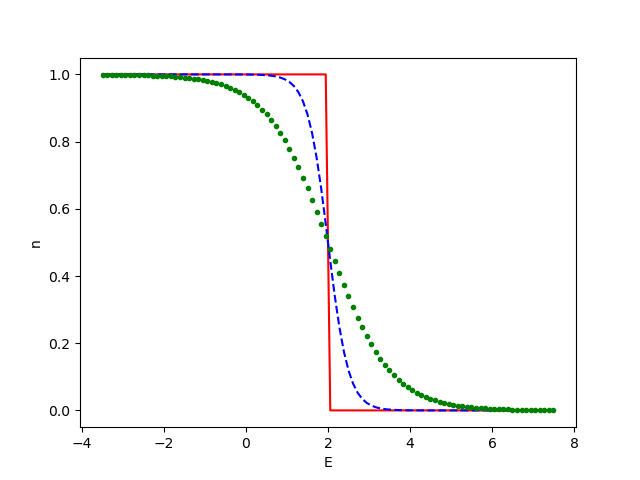

In [13]:
Energy_arr = np.linspace(-3.5, 7.5, 100, endpoint=True)

fig = plt.figure()
Temperatur = 0.0
plt.plot(Energy_arr, FermiDirac(Energy_arr), 'r-')
Temperatur = 0.25
plt.plot(Energy_arr, FermiDirac(Energy_arr), 'b--')
Temperatur = 0.75
plt.plot(Energy_arr, FermiDirac(Energy_arr), 'g.')
plt.ylabel('n')
plt.xlabel('E')

plt.show()

### Expectation Values

\begin{equation}
X_{\alpha \sigma , \beta \sigma'} \left(\vectr{k}\right) = \EW{\cOP{c}_{\vectr{k},\alpha,\sigma}\aOP{c}_{\vectr{k},\beta,\sigma'}}_{\mathrm{eff}} = \sum_{l} 
\left[ \boldsymbol{\xi}^{*}_{l}\left(\vectr{k}\right) \right]_{\alpha \sigma}
\left[ \boldsymbol{\xi}_{l}\left(\vectr{k}\right) \right]_{\beta \sigma'}
f_{\mathrm{FD}}\left(E_{l}\left(\vectr{k}\right)\right)
\end{equation}

respectively

\begin{equation}
X_{\xi,\xi'} \left(\vectr{k}\right) = \EW{\hat{d}^{\dagger}_{\vectr{k},\xi}\hat{d}^{\phantom{\dagger}}_{\vectr{k},\xi'}}_{\mathrm{eff}} = \sum_{l} 
\left[ \boldsymbol{Y}^{\,*}_{l}\left(\vectr{k}\right) \right]_{\xi}
\left[ \boldsymbol{Y}_{l}\left(\vectr{k}\right) \right]_{\xi'}
f_{\mathrm{FD}}\left(E_{l}\left(\vectr{k}\right)\right)
\end{equation}

In [14]:
def X(a,b, eigen_vectors, eigen_energies):
    Xsum = 0.0 + 0.0j
    for cntr in range(2):
        Xsum += np.conj(eigen_vectors[a,cntr])*eigen_vectors[b,cntr]*FermiDirac(eigen_energies[cntr])

    return Xsum

### Free Energy with respect to the Trial Hamiltonian 

\begin{equation}
F(E_l(\vectr{k})) = - \frac{1}{\beta} \ln{\left( 1 + \exp\left( -\beta \left(E_l\left(\vectr{k}\right) - \mu\right) \right) \right)}
\end{equation}

In [15]:
def free_energy(eigen_energy):
    global Chemical_Potential
    global Temperatur
    
    if Temperatur == 0.0:
        if (eigen_energy - Chemical_Potential) < 0.0:
            return (eigen_energy - Chemical_Potential)
        else:
            return 0.0
    elif Temperatur > 0.0:
        return -Temperatur*np.log(1.0 + np.exp(-(1.0/Temperatur)*(eigen_energy - Chemical_Potential)))

    sys.exit('Bad value, T<0.')

### Functional

\begin{equation}
\begin{split}
\Phi\left(\varrho_0, m, \theta \right)
&= \EW{\OP{H}}_{\mathrm{eff}} - \EW{\OP{H}_{\mathrm{eff}}}_{\mathrm{eff}} + \Phi_{\mathrm{eff}} \\
&= \frac{U}{N_{\mathrm{UC}}} \sum_{\alpha}
\left( 
\sum_{\vectr{k}} X_{\alpha \uparrow , \alpha \uparrow} \left(\vectr{k}\right)
\sum_{\vectr{k}'} X_{\alpha \downarrow , \alpha \downarrow} \left(\vectr{k}'\right)
%
-\sum_{\vectr{k}} 
X_{\alpha \uparrow , \alpha \downarrow} \left(\vectr{k}\right) 
\sum_{\vectr{k}'} X_{\alpha \downarrow , \alpha \uparrow} \left(\vectr{k}'\right)\right)\\
%
&- \frac{U}{2} \sum_{\alpha} \varrho^{\phantom{\dagger}}_{\alpha} \sum_{\sigma} \sum_{\vectr{k}} X_{\alpha \sigma, \alpha \sigma} \left(\vectr{k}\right)\\
%
&+ U \sum_{\alpha} m_{\alpha} \left\{ \sin{(\theta_{\alpha})} \sum_{\vectr{k}}
\left[ X_{\alpha \uparrow, \alpha \downarrow} \left(\vectr{k}\right) + X_{\alpha \downarrow, \alpha \uparrow} \left(\vectr{k}\right) \right]
+\cos{(\theta_{\alpha})} \sum_{\vectr{k}}\left[ X_{\alpha \uparrow, \alpha \uparrow} \left(\vectr{k}\right) - X_{\alpha \downarrow, \alpha \downarrow} \left(\vectr{k}\right)\right]\right\}\\
%
&- \frac{1}{\beta} \sum_{\vectr{k}} \sum_{l=1}^{2N_B} \ln{\left( 1 + \exp\left( -\beta \left(E_l\left(\vectr{k}\right) - \mu\right) \right) \right)}
\end{split}
\end{equation}

In [16]:
EV_Magnetisation_Blochparametrization = 0.0
EV_Density_Blochparametrization = 0.0

def Func_UC_1S_Blochparametrization(n,m,theta,Qx,Qy):
    global Hubbard_U
    global kx_grid
    global ky_grid
    global number_of_steps
    
    global effective_Hamiltonian_Blochparametrization
    global full_Hamiltonian_Blochparametrization
    global free_energy_Blochparametrization

    global EV_Density_Blochparametrization
    global EV_Magnetisation_Blochparametrization
    
    sum = 0.0 + 0.0j
    sum_00 = 0.0 + 0.0j
    sum_01 = 0.0 + 0.0j
    sum_10 = 0.0 + 0.0j
    sum_11 = 0.0 + 0.0j
    sum_free_energy = 0.0

    for ikx, kx in enumerate(kx_grid):
        for iky, ky in enumerate(ky_grid):
            w, v = la.eigh(Hamiltonian_UC_1S_Blochparametrization(np.array([kx,ky]),np.array([Qx,Qy]),n,m,theta))
            sum_00 += X(0,0, v, w)
            sum_01 += X(0,1, v, w)
            sum_10 += X(1,0, v, w)
            sum_11 += X(1,1, v, w)
            for vval in w:
                sum_free_energy += free_energy(vval)

    EV_Density_Blochparametrization = np.real(sum_00+sum_11)/(number_of_steps*number_of_steps)
    EV_Magnetisation_Blochparametrization = np.real(sum_00-sum_11)/(number_of_steps*number_of_steps)
                
    effective_Hamiltonian_Blochparametrization  = 0.5*Hubbard_U*n*(sum_00+sum_11)/np.power(number_of_steps,2)\
                                                - Hubbard_U*m*np.sin(theta)*(sum_01+sum_10)/np.power(number_of_steps,2)\
                                                - Hubbard_U*m*np.cos(theta)*(sum_00-sum_11)/np.power(number_of_steps,2)
    full_Hamiltonian_Blochparametrization = Hubbard_U*(sum_00*sum_11 - sum_01*sum_10)/np.power(number_of_steps,4)
    free_energy_Blochparametrization = sum_free_energy/np.power(number_of_steps,2)
    
    sum = full_Hamiltonian_Blochparametrization\
        - effective_Hamiltonian_Blochparametrization\
        + free_energy_Blochparametrization
   
    if np.iscomplex(sum):
        print("COMPLEX:")
        print(sum)

    return np.real(sum)

## Test

In [114]:
Chemical_Potential = 1.0
Hubbard_U = 4.0
Temperatur = 0.0
Q = np.array([np.pi,np.pi])
theta = np.pi

n_steps = np.linspace(0.0, 2.0, 40, endpoint=True)
m_steps = np.linspace(0.0, 0.5, 40, endpoint=True)

functional_mesh_Blochparametrization = np.zeros(shape=(40,40))

f = FloatProgress(min=0, max=20)
display(f)

for idn, n in enumerate(n_steps):
    for idm, m in enumerate(m_steps):
        functional_mesh_Blochparametrization[idm][idn] = Func_UC_1S_Blochparametrization(n,m,theta,Q[0],Q[1])
    f.value += 1

np.save('functional_mesh_Blochparametrization', functional_mesh_Blochparametrization)

FloatProgress(value=0.0, max=20.0)

<IPython.core.display.Javascript object>


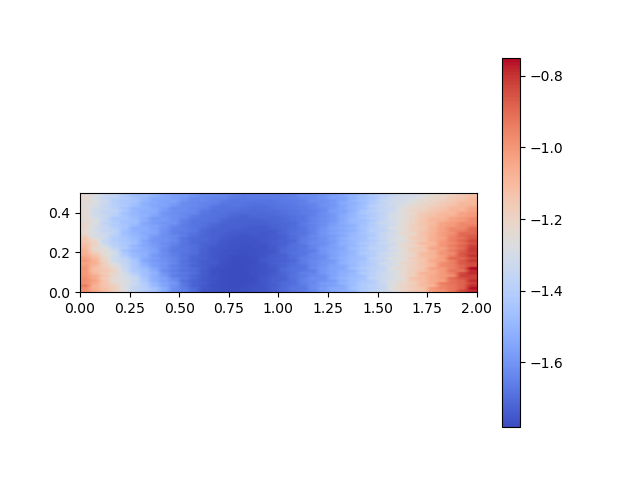

In [115]:
#functional_mesh = np.load('functional_mesh_Blochparametrization.npy')
functional_mesh = functional_mesh_Blochparametrization

fig_functional_map = plt.figure()
im = plt.imshow(functional_mesh, extent=(0.0,2.0,0.0,0.5), origin='lower', cmap=cm.coolwarm) # drawing the function
#plt.xticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
#plt.yticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
# adding the Contour lines with labels
#cset = plt.contour(kx, ky, Band_1,np.arange(-4,4.0,1.0),linewidths=2,cmap=cm.Set2)
#plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#plt.colorbar(im) # adding the colobar on the right
plt.colorbar() # adding the colobar on the right
#plt.xticks([1,2])
# latex fashion title
plt.show()

<IPython.core.display.Javascript object>


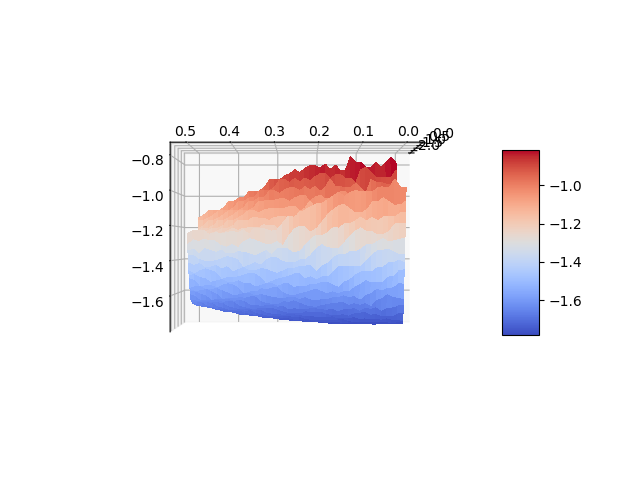

/tmp/ipykernel_18424/1206579308.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [116]:
ngrid, mgrid = np.meshgrid(n_steps, m_steps)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(ngrid, mgrid, functional_mesh, rstride=1, cstride=1, 
                      cmap=cm.coolwarm,linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1500.0, -750.0)
#ax.set_ylim(-1.0, 1.0)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Wrap für m Einschränkung

In [70]:
def MinFunc_Wrap_UC_1S_Blochparametrization(x):
    n = x[0]
    m = x[1]*0.5*(1.0-np.fabs(1-x[0]))
    theta = np.pi
    qx = np.pi
    qy = np.pi
    
    return Func_UC_1S_Blochparametrization(n,m,theta,qx,qy)

In [117]:
Chemical_Potential = 1.0
Hubbard_U = 4.0
Temperatur = 0.0
Q = np.array([np.pi,np.pi])
theta = np.pi

In [118]:
#n_steps = 20
#m_steps = 20

n_steps = np.linspace(0.0, 2.0, 40, endpoint=True)
m_steps = np.linspace(0.0, 1.0, 40, endpoint=True)

functional_mesh = np.zeros(shape=(40,40))

f = FloatProgress(min=0, max=20)
display(f)

for idn, n in enumerate(n_steps):
    for idm, m in enumerate(m_steps):
        functional_mesh[idm][idn] = MinFunc_Wrap_UC_1S_Blochparametrization(np.array([n,m]))
    f.value += 1

FloatProgress(value=0.0, max=20.0)

<IPython.core.display.Javascript object>


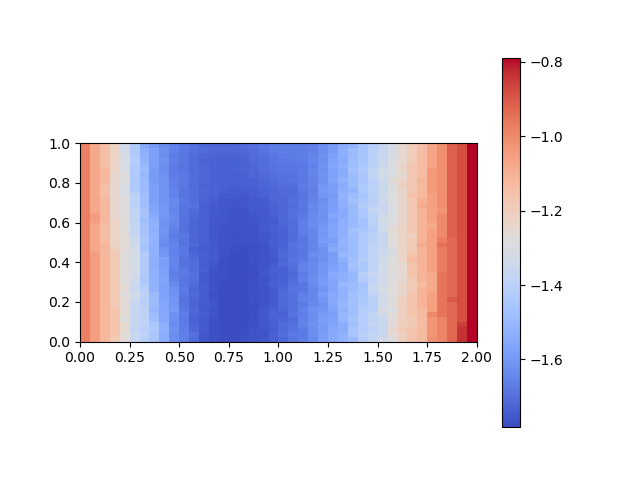

In [119]:
fig_functional_map = plt.figure()
im = plt.imshow(functional_mesh, extent=(0.0,2.0,0.0,1.0), origin='lower', cmap=cm.coolwarm) # drawing the function
#plt.xticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
#plt.yticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
# adding the Contour lines with labels
#cset = plt.contour(kx, ky, Band_1,np.arange(-4,4.0,1.0),linewidths=2,cmap=cm.Set2)
#plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#plt.colorbar(im) # adding the colobar on the right
plt.colorbar() # adding the colobar on the right
#plt.xticks([1,2])
# latex fashion title
plt.show()

<IPython.core.display.Javascript object>


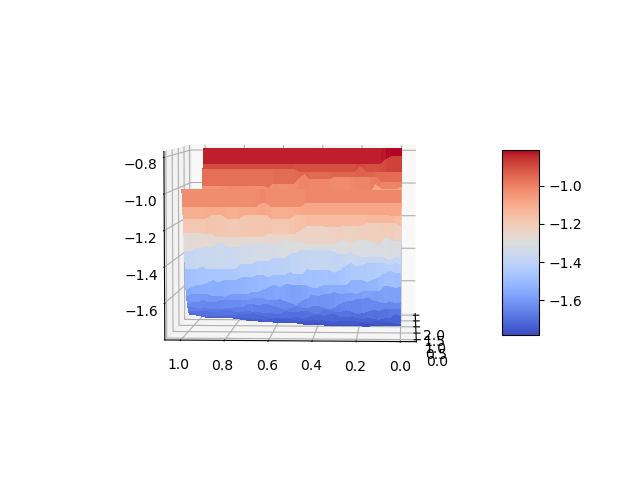

/tmp/ipykernel_18424/1206579308.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [120]:
ngrid, mgrid = np.meshgrid(n_steps, m_steps)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(ngrid, mgrid, functional_mesh, rstride=1, cstride=1, 
                      cmap=cm.coolwarm,linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1500.0, -750.0)
#ax.set_ylim(-1.0, 1.0)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### The Minimization

In [ ]:
Temperatur = 0.0
Chemical_Potential = 0.0
Hubbard_U = 4.0

In [ ]:
#bounds = [(0,2), (0.0, 1.0), (0.0,np.pi), (0.0,np.pi)]
bounds = [(0,2), (0.0, 1.0)]

In [ ]:
%%timeit -n 1 -r 1
result = shgo(MinFunc_Wrap_UC_1S, bounds, n=100, iters=5, sampling_method='sobol')
print(result.x,result.fun)

In [ ]:
%%timeit -n 1 -r 1
result = shgo(MinFunc_Wrap_UC_1S, bounds, iters=4, options={'disp': True, 'maxtime': 10})
print(result.x,result.fun)

In [ ]:
%%timeit -n 1 -r 1
init_arr = np.array([[1.0,1.0,0.5*np.pi,np.pi,np.pi],\
                     [1.0,0.5,0.5*np.pi,np.pi,np.pi],\
                     [1.0,1.0,0.5*np.pi,0.0,np.pi],\
                     [1.0,1.0,0.5*np.pi,np.pi,0.0],\
                     [1.0,1.0,0.0,0.0,0.0]])
result = differential_evolution(MinFunc_Wrap_UC_1S,\
                                bounds,\
                                disp=True,\
                                maxiter=10,\
                                updating='deferred',\
                                workers=-1)
print(result.x,result.fun)

In [ ]:
%%timeit -n 1 -r 1
result = dual_annealing(MinFunc_Wrap_UC_1S, bounds, maxiter=500)
print(result.x,result.fun)

In [ ]:
chem_pot_number_of_steps = 60
chem_pot_arr = np.linspace(-3.0, 3.0, chem_pot_number_of_steps, endpoint=True)

n_arr = np.zeros(chem_pot_number_of_steps)
m_arr = np.zeros(chem_pot_number_of_steps)
m_res_arr = np.zeros(chem_pot_number_of_steps)
theta_arr = np.zeros(chem_pot_number_of_steps)
qx_arr = np.zeros(chem_pot_number_of_steps)
qy_arr = np.zeros(chem_pot_number_of_steps)
fct_arr = np.zeros(chem_pot_number_of_steps)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, dpi=120)

ax1.set_ylabel('n')
ax1.set_xlabel('$\mu$')
ax2.set_ylabel('m')
ax2.set_xlabel('$\mu$')
ax3.set_ylabel('E')
ax3.set_xlabel('$\mu$')

chempotbar = FloatProgress(min=0, max=chem_pot_number_of_steps)
display(chempotbar)

#minimizer_kwargs = {"method":"L-BFGS-B"}
#x0 = [0.0, 0.0, 0.0, 0.0]
init_arr = np.array([[0.05,0.01]])
    
for idchem_pot, chem_pot in enumerate(chem_pot_arr):
    Chemical_Potential = chem_pot
        
    #result = shgo(MinFunc_Wrap, bounds)
    #result = shgo(MinFunc_Wrap_UC_1S, bounds, iters=3)
    #result = dual_annealing(MinFunc_Wrap, bounds, maxiter=200)
    #result = differential_evolution(MinFunc_Wrap_UC_1S, bounds, maxiter=1000, updating='deferred', workers=-1)
    result = differential_evolution(MinFunc_Wrap_UC_1S_Blochparametrization,\
                                    bounds,\
                                    polish=False,\
                                    disp=False,\
                                    maxiter=10,\
                                    updating='deferred',\
                                    workers=-1)

    n_arr[idchem_pot] = result.x[0]
    m_arr[idchem_pot] = result.x[1]
    fct_arr[idchem_pot] = result.fun
    chempotbar.value += 1
    
    ax1.plot(chem_pot_arr, n_arr, 'go', label='n')
    ax2.plot(chem_pot_arr, m_arr, 'b*', label='m')
    ax3.plot(chem_pot_arr, fct_arr, 'r*', label='Free Energy')
    display(fig)
    clear_output(wait = True)
    plt.pause(0.5)

In [ ]:
chem_pot_number_of_steps = 60
chem_pot_arr = np.linspace(-3.0, 3.0, chem_pot_number_of_steps, endpoint=True)

n_arr_afm = np.zeros(chem_pot_number_of_steps)
ev_n_arr_afm = np.zeros(chem_pot_number_of_steps)
m_arr_afm = np.zeros(chem_pot_number_of_steps)
ev_m_arr_afm = np.zeros(chem_pot_number_of_steps)
m_res_arr_afm = np.zeros(chem_pot_number_of_steps)
fct_arr_afm = np.zeros(chem_pot_number_of_steps)

# Create Figure and Subplots
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,10), dpi=120)

# Plot
ax1.set_ylabel('n')
ax1.set_xlabel('$\mu$')
ax1.plot(chem_pot_arr, n_arr_afm, 'go', label='n')

ax2.set_ylabel('m')
ax2.set_xlabel('$\mu$')
ax2.plot(chem_pot_arr, m_arr_afm, 'b*', label='m')
ax2.plot(chem_pot_arr, m_res_arr_afm, 'r-', label='m')

ax3.set_ylabel('E')
ax3.set_xlabel('$\mu$')
ax3.plot(chem_pot_arr, fct_arr_afm, 'r*', label='Free Energy')

plt.ion()

fig.show()
fig.canvas.draw()

chempotbar = FloatProgress(min=0, max=chem_pot_number_of_steps)
display(chempotbar)

#init_arr = np.array([[0.05,0.01],\
#                     [0.5,0.5],\
#                     [1.0,1.0],\
#                     [2.0,1.0],\
#                     [2.0,0.0]])
    
for idchem_pot, chem_pot in enumerate(chem_pot_arr):
    Chemical_Potential = chem_pot
    
    #result = shgo(MinFunc_Wrap_UC_1S_afm, bounds, n=100, iters=5)
    #result = shgo(MinFunc_Wrap, bounds)
    #result = shgo(MinFunc_Wrap_UC_1S_afm, bounds, iters=3)
    #result = dual_annealing(MinFunc_Wrap, bounds, maxiter=200)
    #result = differential_evolution(MinFunc_Wrap_UC_1S, bounds, maxiter=1000, updating='deferred', workers=-1)
    result = differential_evolution(MinFunc_Wrap_UC_1S_Blochparametrization,\
                                    bounds,\
                                    #init=init_arr,\
                                    #polish=False,\
                                    #disp=False,\
                                    maxiter=50,\
                                    updating='deferred',\
                                    workers=-1)
    
#    init_arr = np.array([[result.x[0],result.x[1]],\
#                         [0.05,0.01],\
#                         [0.5,0.5],\
#                         [1.0,1.0],\
#                         [2.0,1.0],\
#                         [2.0,0.0]])
    if result.success == True:
        n_arr_afm[idchem_pot] = result.x[0]
        ev_n_arr_afm[idchem_pot] = EV_Density_Blochparametrization
        m_arr_afm[idchem_pot] = result.x[1]
        ev_m_arr_afm[idchem_pot] = EV_Magnetisation_Blochparametrization
        m_res_arr_afm[idchem_pot] = result.x[1]*(1.0-np.fabs(1.0-result.x[0]))
        fct_arr_afm[idchem_pot] = result.fun
    else:
        print("no convergence.")

    chempotbar.value += 1
    
    ax1.clear()
    ax1.plot(chem_pot_arr, n_arr_afm, 'go', label='n')
    ax1.plot(chem_pot_arr, ev_n_arr_afm, 'b*', label='ev')
    ax2.clear()
    ax2.plot(chem_pot_arr, m_arr_afm, 'b*', label='m')
    ax2.plot(chem_pot_arr, ev_m_arr_afm, 'go', label='ev')
    ax2.plot(chem_pot_arr, m_res_arr_afm, 'r-', label='m_res')
    ax3.clear()
    ax3.plot(chem_pot_arr, fct_arr_afm, 'r*', label='Free Energy')
    fig.canvas.draw()

# The Spin Base Transformation Approaches

## Model
$$\newcommand{\OP}[1]{\hat{#1}}$$
$$\newcommand{\vectr}[1]{\boldsymbol{#1}}$$

The Hubbard model Hamiltonian for a single site unit cell reads:

\begin{equation}
\OP{H} = \sum_{i,j}\sum_{\sigma} t^{\phantom{\dagger}}_{i,j} \hat{c}^{\dagger}_{i,\sigma} \hat{c}^{\phantom{\dagger}}_{j,\sigma}
 + U \sum_{i}\hat{n}^{\phantom{\dagger}}_{i,\uparrow}\hat{n}^{\phantom{\dagger}}_{i,\downarrow}
\end{equation}

with $\hat{n}^{\phantom{\dagger}}_{i,\sigma} =  \hat{c}^{\dagger}_{i,\sigma} \hat{c}^{\phantom{\dagger}}_{i,\sigma}$. The integer index set $\{i,j\}$ labels the respective cells originating from shifting the unit cell (UC) by integral multiples of the translation vectors. The number of cells will be labeled $N_{\mathrm{UC}}$.

### Unitary Transformation to Local Spin Axis

\begin{equation}
\hat{c}^{\phantom{\dagger}}_{i,\sigma} = \sum_{\xi} \left[U(\theta_i,\varphi_i)\right]_{\sigma,\xi}\, \hat{d}^{\phantom{\dagger}}_{i,\xi}
\end{equation}

with $\xi\in\{+,-\}$, meaning the spin $S^{z}$ quantum number along the local spin quantization axis and:

\begin{equation}
U(\theta_i,\varphi_i) = \exp{\left(-i\frac{\varphi_{i}}{2}\sigma_{z}\right)}\exp{\left(-i\frac{\theta_{i}}{2}\sigma_{y}\right)} = 
\begin{pmatrix}
e^{-i\frac{\varphi_{i}}{2}} & 0\\
0 & e^{i\frac{\varphi_{i}}{2}}
\end{pmatrix}
\begin{pmatrix}
\cos{\left(\frac{\theta_{i}}{2}\right)} & -\sin{\left(\frac{\theta_{i}}{2}\right)}\\
\sin{\left(\frac{\theta_{i}}{2}\right)} & \cos{\left(\frac{\theta_{i}}{2}\right)}
\end{pmatrix}
=
\begin{pmatrix}
\cos{\left(\frac{\theta_{i}}{2}\right)} e^{-i\frac{\varphi_{i}}{2}} & -\sin{\left(\frac{\theta_{i}}{2}\right)} e^{-i\frac{\varphi_{i}}{2}}\\
\sin{\left(\frac{\theta_{i}}{2}\right)} e^{i\frac{\varphi_{i}}{2}} & \cos{\left(\frac{\theta_{i}}{2}\right)} e^{i\frac{\varphi_{i}}{2}}
\end{pmatrix}
\end{equation}

The transformed Hamiltonian reads

\begin{equation}
\OP{H} = \underbrace{\sum_{i,j}\sum_{\xi,\xi'} t^{\phantom{\dagger}}_{i,j} \hat{d}^{\dagger}_{i,\xi} \left[U^{\dagger}(\theta_i,\varphi_i) U(\theta_j,\varphi_j) \right]_{\xi,\xi'} \hat{d}^{\phantom{\dagger}}_{j,\xi'}}_{=: \OP{H}_0}
 + \underbrace{U \sum_{i} \hat{d}^{\dagger}_{i,+} \hat{d}^{\phantom{\dagger}}_{i,+} \hat{d}^{\dagger}_{i,-} \hat{d}^{\phantom{\dagger}}_{i,-}}_{=: \OP{H}_\mathrm{I}}
\end{equation}

In the following we consider:

\begin{equation}
t^{\phantom{\dagger}}_{i,j} = t
\end{equation}

### Interaction

The transformation of the spin base acts only on the hopping. The onsite Hubbard interaction is invariant under the transform. Therefore the derivation of the interaction part of the trail Hamiltonian as well as the mathematical structure of effective and full interaction remain the same.

\begin{equation}
\OP{H}_\mathrm{I} = U \sum_{i} \hat{d}^{\dagger}_{i,+} \hat{d}^{\phantom{\dagger}}_{i,+} \hat{d}^{\dagger}_{i,-} \hat{d}^{\phantom{\dagger}}_{i,-} = U \sum_{i} \hat{d}^{\dagger}_{i,+} \hat{d}^{\dagger}_{i,-} \hat{d}^{\phantom{\dagger}}_{i,-} \hat{d}^{\phantom{\dagger}}_{i,+} \approx \OP{H}_\mathrm{I}^{HF} = U \sum_{i} \left( \frac{1}{2} \varrho^{\phantom{\dagger}}_{i} \hat{n}^{\phantom{\dagger}}_{i} - 2\,\mathbf{m}^{\phantom{\dagger}}_{i}\cdot \OP{\mathbf{S}}_{i}^{\phantom{\dagger}} \right)
\end{equation}

with

\begin{equation}
\hat{\mathbf{S}}_{i}
= \frac{1}{2}
\begin{pmatrix}
\phantom{i}\hat{d}^{\dagger}_{i,+}\hat{d}^{\phantom{\dagger}}_{i,-}
+ \phantom{i}\hat{d}^{\dagger}_{i,-}\hat{d}^{\phantom{\dagger}}_{i,+}\\
%
i\hat{d}^{\dagger}_{i,-}\hat{d}^{\phantom{\dagger}}_{i,+}
- i\hat{d}^{\dagger}_{i,+}\hat{d}^{\phantom{\dagger}}_{i,-}\\
%
\phantom{i}\hat{d}^{\dagger}_{i,+}\hat{d}^{\phantom{\dagger}}_{i,+}
- \phantom{i}\hat{d}^{\dagger}_{i,-}\hat{d}^{\phantom{\dagger}}_{i,-}\\
\end{pmatrix}
\end{equation}

and 

\begin{equation}
\hat{n}^{\phantom{\dagger}}_{i} = \hat{d}^{\dagger}_{i,+} \hat{d}^{\phantom{\dagger}}_{i,+} + \hat{d}^{\dagger}_{i,-} \hat{d}^{\phantom{\dagger}}_{i,-}
\end{equation}

Restriction to $S^{z}$ - component and 1 site unit cell:

\begin{align}
\varrho_{i} &\rightarrow \varrho\\
m^{z}_{i} &\rightarrow m^{z}
\end{align}

yielding:

\begin{equation}
\OP{H}_\mathrm{I}^{HF} = U \sum_{i} \left( \frac{1}{2} \varrho^{\phantom{\dagger}} \left(\hat{d}^{\dagger}_{i,+} \hat{d}^{\phantom{\dagger}}_{i,+} + \hat{d}^{\dagger}_{i,-} \hat{d}^{\phantom{\dagger}}_{i,-}\right) - m^{z}\left(\hat{d}^{\dagger}_{i,+}\hat{d}^{\phantom{\dagger}}_{i,+}
-\hat{d}^{\dagger}_{i,-}\hat{d}^{\phantom{\dagger}}_{i,-} \right) \right)
\end{equation}

Fourier Transformation:

\begin{equation}
\OP{H}_\mathrm{I}^{HF} = U \sum_{\vectr{k}} \left( \frac{1}{2} \varrho^{\phantom{\dagger}} \left(\hat{d}^{\dagger}_{\vectr{k},+} \hat{d}^{\phantom{\dagger}}_{\vectr{k},+} + \hat{d}^{\dagger}_{\vectr{k},-} \hat{d}^{\phantom{\dagger}}_{\vectr{k},-}\right) - m^{z}\left(\hat{d}^{\dagger}_{\vectr{k},+}\hat{d}^{\phantom{\dagger}}_{\vectr{k},+}
-\hat{d}^{\dagger}_{\vectr{k},-}\hat{d}^{\phantom{\dagger}}_{\vectr{k},-} \right) \right)
\end{equation}

## The Grand Canonical Functional

$\newcommand{\cOP}[1]{{\hat{#1}^{\dagger}}}$
$\newcommand{\aOP}[1]{{\hat{#1}^{\phantom{\dagger}}}}$

$\newcommand{\EW}[1]{\left<{#1}\right>}$
$\DeclareMathOperator{\Tr}{Tr}$

\begin{equation*}
\Phi\left[\OP{\rho}_{\mathrm{eff}}\right] =
\EW{\OP{H}}_{\mathrm{eff}} - \EW{\OP{H}_{\mathrm{eff}}}_{\mathrm{eff}} + \Phi_{\mathrm{eff}} 
\geq \Phi\left[ \OP{\rho}_{\mathrm{GK}} \right] = \Omega(T,\mu)
\end{equation*}

with the standard grand potential for the effective density operator:

\begin{equation*}
 \Phi_{\mathrm{eff}} = -k_BT \ln{\left(Z_{\mathrm{eff}}\right)} = -k_BT \ln{\left(\Tr\left\{e^{-\beta\left(\OP{H}_{\mathrm{eff}}-\mu\OP{N}\right)} \right\}\right)}.
\end{equation*}

We choose a proper trial hamiltonian, which is the Hartree Fock decoupled one of the previous section here. This induces the parametrization of the effective statistical operator as a consequence and thus, results in the scalar field $\Phi\left(\{ \vectr{Q}_{\theta}, \varrho, m^z \}; \OP{\rho}_{\mathrm{eff}} \right)$ depending on the chosen set of parameters:

\begin{equation*}
 \Phi\left[\OP{\rho}_{\mathrm{eff}}\right] \rightarrow \Phi\left(\{ \vectr{Q}_{\theta}, \varrho, m^z \}; \OP{\rho}_{\mathrm{eff}} \right).
\end{equation*}

Assembling all terms, effective charge interaction term, effective spin interaction term,
full interaction term, and effective grand potential yields:

\begin{equation}
\begin{split}
\Phi\left[\OP{\rho}_{\mathrm{eff}}\right] 
&= \frac{U}{N_{\mathrm{UC}}} \left(\sum_{\vectr{k}} X_{+,+} \left(\vectr{k}\right) \sum_{\vectr{k}'} X_{-,-} \left(\vectr{k}'\right)
    -\sum_{\vectr{k}} X_{+,-} \left(\vectr{k}\right) \sum_{\vectr{k}'} X_{-,+} \left(\vectr{k}'\right) \right)\\
%
&- \frac{U}{2} \varrho^{\phantom{\dagger}} \sum_{\xi} \sum_{\vectr{k}} X_{\xi,\xi} \left(\vectr{k}\right)\\
%
&+ U m^{z} \sum_{\vectr{k}} \left( X_{+,+} \left(\vectr{k}\right) - X_{-,-} \left(\vectr{k}\right)\right)\\
%
&- \frac{1}{\beta} \sum_{\vectr{k}} \sum_{l=1}^{2N_B} \ln{\left( 1 + \exp\left( -\beta \left(E_l\left(\vectr{k}\right) - \mu\right) \right) \right)}
\end{split}
\end{equation}

with

\begin{equation}
X_{\xi , \xi'} \left(\vectr{k}\right) = \EW{\hat{d}^{\dagger}_{\vectr{k},\xi} \hat{d}^{\phantom{\dagger}}_{\vectr{k},\xi'}}_{\mathrm{eff}} = \sum_{l} 
\left[ \boldsymbol{Y}^{\,*}_{l}\left(\vectr{k}\right) \right]_{\xi}
\left[ \boldsymbol{Y}_{l}\left(\vectr{k}\right) \right]_{\xi'}
f_{\mathrm{FD}}\left(E_{l}\left(\vectr{k}\right)\right)
\end{equation}

and introducing the Fermi-Dirac distribution function:

\begin{equation}
\EW{\OP{n}_{\lambda}}_{\mathrm{eff}} = f_{\mathrm{FD}}\left(\varepsilon_\lambda\right) = \frac{1}{e^{\beta\left(\varepsilon_\lambda - \mu\right)} + 1},
\end{equation}

Please note that:

\begin{equation}
\EW{\hat{d}^{\dagger}_{i,\xi}\hat{d}^{\phantom{\dagger}}_{i,\xi}}_{\mathrm{eff}}
= \sum_{\vectr{k}} X_{\xi,\xi'} \left(\vectr{k}\right).
\end{equation}

The indexing of sites $\alpha$ and spin $\sigma$ is insufficient for labeling the elements of eigen vectors. Therefore, we use the bijective indexing

\begin{equation}
 a = 2(\alpha - 1) + \sigma
\end{equation}

with 

- spin index $\sigma\in\{0 (\uparrow),1 (\downarrow)\}$
- site index $\alpha\in\{1,2,\dots,N_B\}$

This is also the preferred labeling scheme of matrix elements used in the actual implementation.

## The Fixed Polar Angle Approach

# The Fixed Azimuth Angle Approach

We consider

\begin{align}
\theta_{i} &= \vectr{Q}_{\theta}\cdot\vectr{R}_i\\
\varphi_{i} &= \mathrm{const} = \varphi
\end{align}

with that:

\begin{align}
\left[U^{\dagger}(\theta_i,\varphi_i) U(\theta_j,\varphi_j) \right]_{+,+} &= \cos{\left( \frac{1}{2} \vectr{Q}_{\theta}\cdot \left(\vectr{R}_i - \vectr{R}_j \right)\right)}\\
\left[U^{\dagger}(\theta_i,\varphi_i) U(\theta_j,\varphi_j) \right]_{+,-} &= \sin{\left( \frac{1}{2} \vectr{Q}_{\theta}\cdot \left(\vectr{R}_i - \vectr{R}_j \right)\right)}\\
\left[U^{\dagger}(\theta_i,\varphi_i) U(\theta_j,\varphi_j) \right]_{-,+} &= -\sin{\left( \frac{1}{2} \vectr{Q}_{\theta}\cdot \left(\vectr{R}_i - \vectr{R}_j \right)\right)}\\
\left[U^{\dagger}(\theta_i,\varphi_i) U(\theta_j,\varphi_j) \right]_{-,-} &= \cos{\left( \frac{1}{2} \vectr{Q}_{\theta}\cdot \left(\vectr{R}_i - \vectr{R}_j \right)\right)}\\
\end{align}

### Hopping


The Fourier transformation of the general hoping term $\OP{H}_0$ reads:

\begin{align}
 \OP{H}_0 = \sum_{\vectr{k}} &\left(\hat{d}^{\dagger}_{\vectr{k},+} \hat{d}^{\phantom{\dagger}}_{\vectr{k},+} \sum_{\vectr{\eta}_j} t\, e^{i\vectr{k}\cdot\vectr{\eta}_j} \cos{\left(\frac{1}{2} \vectr{Q}_{\theta}\cdot\vectr{\eta}_j\right)} \right.\\
 &+\hat{d}^{\dagger}_{\vectr{k},+} \hat{d}^{\phantom{\dagger}}_{\vectr{k},-} \sum_{\vectr{\eta}_j} t\, e^{i\vectr{k}\cdot\vectr{\eta}_j} \sin{\left(\frac{1}{2} \vectr{Q}_{\theta}\cdot\vectr{\eta}_j\right)}\\
 &-\hat{d}^{\dagger}_{\vectr{k},-} \hat{d}^{\phantom{\dagger}}_{\vectr{k},+} \sum_{\vectr{\eta}_j} t\, e^{i\vectr{k}\cdot\vectr{\eta}_j} \sin{\left(\frac{1}{2} \vectr{Q}_{\theta}\cdot\vectr{\eta}_j\right)}\\
 &+\left.\hat{d}^{\dagger}_{\vectr{k},-} \hat{d}^{\phantom{\dagger}}_{\vectr{k},-} \sum_{\vectr{\eta}_j} t\, e^{i\vectr{k}\cdot\vectr{\eta}_j} \cos{\left(\frac{1}{2} \vectr{Q}_{\theta}\cdot\vectr{\eta}_j\right)} \right)
\end{align}

and for the **square lattice**:

\begin{align}
 \OP{H}_0 = \sum_{\vectr{k}} &\left(\hat{d}^{\dagger}_{\vectr{k},+} \hat{d}^{\phantom{\dagger}}_{\vectr{k},+} 2t \left( \cos{(k_x)} \cos{\left(\frac{1}{2} \vectr{Q}^{x}_{\theta}\right)} + \cos{(k_y)} \cos{\left(\frac{1}{2} \vectr{Q}^{y}_{\theta}\right)}\right)\right.\\
 &+\hat{d}^{\dagger}_{\vectr{k},+} \hat{d}^{\phantom{\dagger}}_{\vectr{k},-} i2t \left( \sin{(k_x)} \sin{\left(\frac{1}{2} \vectr{Q}^{x}_{\theta}\right)} + \sin{(k_y)} \sin{\left(\frac{1}{2} \vectr{Q}^{y}_{\theta}\right)}\right)\\
 &-\hat{d}^{\dagger}_{\vectr{k},-} \hat{d}^{\phantom{\dagger}}_{\vectr{k},+} i2t \left( \sin{(k_x)} \sin{\left(\frac{1}{2} \vectr{Q}^{x}_{\theta}\right)} + \sin{(k_y)} \sin{\left(\frac{1}{2} \vectr{Q}^{y}_{\theta}\right)}\right)\\
 &+\left.\hat{d}^{\dagger}_{\vectr{k},-} \hat{d}^{\phantom{\dagger}}_{\vectr{k},-} 2t \left( \cos{(k_x)} \cos{\left(\frac{1}{2} \vectr{Q}^{x}_{\theta}\right)} + \cos{(k_y)} \cos{\left(\frac{1}{2} \vectr{Q}^{y}_{\theta}\right)}\right) \right)
\end{align}

compact:

\begin{equation}
\OP{H}_0 = \sum_{\vectr{k}} \sum_{\xi,\xi'} \hat{d}^{\dagger}_{\vectr{k},\xi} \left[ T_e(\vectr{k},\vectr{Q_{\theta}})\boldsymbol{1} - T_0(\vectr{k},\vectr{Q_{\theta}})\sigma_{y} \right]_{\xi,\xi'} \hat{d}^{\phantom{\dagger}}_{\vectr{k},\xi'}
\end{equation}

with

\begin{equation}
\sigma_{y} = 
\begin{pmatrix}
0 &-i\\
i &0
\end{pmatrix}
\end{equation}

and

\begin{align}
 T_e &= 2t \left( \cos{(k_x)} \cos{\left(\frac{1}{2} \vectr{Q}^{x}_{\theta}\right)} + \cos{(k_y)} \cos{\left(\frac{1}{2} \vectr{Q}^{y}_{\theta}\right)}\right)\\
 T_0 &= 2t \left( \sin{(k_x)} \sin{\left(\frac{1}{2} \vectr{Q}^{x}_{\theta}\right)} + \sin{(k_y)} \sin{\left(\frac{1}{2} \vectr{Q}^{y}_{\theta}\right)}\right) 
\end{align}

In [75]:
def Te(k,Q):
    return -2.0*(np.cos(k[0])*np.cos(0.5*Q[0]) + np.cos(k[1])*np.cos(0.5*Q[1]))

def iTo(k,Q):
    return -2.0*(np.sin(k[0])*np.sin(0.5*Q[0]) + np.sin(k[1])*np.sin(0.5*Q[1]))*1.0j

### The Trial Hamiltonian

\begin{equation}
\OP{H}^{\mathrm{HF}} = \sum_{\vectr{k}} \sum_{\xi,\xi'} \hat{d}^{\dagger}_{\vectr{k},\xi} \left[\left(T_e(\vectr{k},\vectr{Q}_{\theta}) + \frac{U}{2}\varrho\right)\boldsymbol{1} - T_0(\vectr{k},\vectr{Q}_{\theta})\sigma_{y} - Um^{z}\sigma_{z} \right]_{\xi,\xi'} \hat{d}^{\phantom{\dagger}}_{\vectr{k},\xi'}
\end{equation}

with

\begin{equation}
\sigma_{z} = 
\begin{pmatrix}
1 &0\\
0 &-1
\end{pmatrix}
\end{equation}

detailed

\begin{equation}
\begin{split}
\OP{H}^{\mathrm{HF}} 
= \sum_{\vectr{k}}
&\left(\hat{d}^{\dagger}_{\vectr{k},+} 
\mathcal{H}^{++} \left(\vectr{k},\vectr{Q}_{\theta}\right)\, 
\hat{d}^{\phantom{\dagger}}_{\vectr{k},+}
%
+\hat{d}^{\dagger}_{\vectr{k},+} 
\mathcal{H}^{+-} \left(\vectr{k},\vectr{Q}_{\theta}\right)\, 
\hat{d}^{\phantom{\dagger}}_{\vectr{k},-}\right.\\
%
+&\left.\hat{d}^{\dagger}_{\vectr{k},-} 
\mathcal{H}^{-+} \left(\vectr{k},\vectr{Q}_{\theta}\right)\,
\hat{d}^{\phantom{\dagger}}_{\vectr{k},+}
%
+\hat{d}^{\dagger}_{\vectr{k},-}
\mathcal{H}^{--} \left(\vectr{k},\vectr{Q}_{\theta}\right)\,
\hat{d}^{\phantom{\dagger}}_{\vectr{k},-}\right)
%
\end{split}
\end{equation}

with the matrix elements for spin and charge decoupling read:

\begin{align}
\mathcal{H}^{++} \left(\vectr{k},\vectr{Q_{\theta}}\right) &= 2t \left( \cos{(k_x)} \cos{\left(\frac{1}{2} {Q}^{x}_{\theta}\right)} + \cos{(k_y)} \cos{\left(\frac{1}{2} {Q}^{y}_{\theta}\right)}\right) + \frac{U}{2}\varrho - Um^{z}\\
%
\mathcal{H}^{+-} \left(\vectr{k},\vectr{Q_{\theta}}\right) &= i2t \left( \sin{(k_x)} \sin{\left(\frac{1}{2} {Q}^{x}_{\theta}\right)} + \sin{(k_y)} \sin{\left(\frac{1}{2} {Q}^{y}_{\theta}\right)}\right)\\
%
\mathcal{H}^{-+} \left(\vectr{k},\vectr{Q_{\theta}}\right) &= -i2t \left( \sin{(k_x)} \sin{\left(\frac{1}{2} {Q}^{x}_{\theta}\right)} + \sin{(k_y)} \sin{\left(\frac{1}{2} {Q}^{y}_{\theta}\right)}\right)\\
%
\mathcal{H}^{--} \left(\vectr{k},\vectr{Q_{\theta}}\right) &= 2t \left( \cos{(k_x)} \cos{\left(\frac{1}{2} {Q}^{x}_{\theta}\right)} + \cos{(k_y)} \cos{\left(\frac{1}{2} {Q}^{y}_{\theta}\right)}\right) + \frac{U}{2}\varrho + Um^{z}\\
\end{align}

Indexing Matrix elements

\begin{equation}
 a = 2(\alpha - 1) + \xi
\end{equation}

with spin index $\xi\in\{0 (+),1 (-)\}$ and site index $\alpha\in\{1,2,\dots,N_B\}$

In [76]:
def Hamiltonian_UC_1S_Fixed_Azimuth(k,Q,n,m):
    """"Returns np.array like Matrix"""
    
    A = np.zeros((2, 2), dtype=complex)
    
    A[0][0] = Te(k,Q) + 0.5*Hubbard_U*n - Hubbard_U*m
        
    A[0][1] = iTo(k,Q)
    
    A[1][0] = -iTo(k,Q)
    
    A[1][1] = Te(k,Q) + 0.5*Hubbard_U*n + Hubbard_U*m

    return A

## Test Hamiltonian

In [77]:
print("Hubbard_U: " + str(Hubbard_U))
print("Q-vector: " + str(Q))
print("n: " + str(n))
print("m: " + str(m))
Hamiltonian_UC_1S_Fixed_Azimuth(np.array([0.0,0.0]),Q,n,m)

Hubbard_U: 10.0
Q-vector: [3.14159265 3.14159265]
n: 2.0
m: 1.0


array([[ 0.+0.j, -0.+0.j],
       [ 0.-0.j, 20.+0.j]])

## Bandstructure

In [78]:
def Set_Spectrum_Bands_UC_1S_Fixed_Azimuth(Q,n,m):
    Band_1 = np.zeros((1,number_of_steps))
    tempBand_1 = np.zeros(number_of_steps)

    Band_2 = np.zeros((1,number_of_steps))
    tempBand_2 = np.zeros(number_of_steps)
     
    for ky in ky_grid:
        for idx, kx in enumerate(kx_grid):
            w, v = la.eigh(Hamiltonian_UC_1S_Fixed_Azimuth(np.array([kx,ky]),Q,n,m))
            tempBand_1[idx] = w[0]
            tempBand_2[idx] = w[1]
        Band_1 = np.concatenate((Band_1,[tempBand_1]), axis=0)
        Band_2 = np.concatenate((Band_2,[tempBand_2]), axis=0)
    
    Band_1 = np.delete(Band_1, 0, 0)
    Band_2 = np.delete(Band_2, 0, 0)
    return Band_1, Band_2

def get_Bands_UC_1S_Fixed_Azimuth(k,Q,n,m):
    w, v = la.eigh(Hamiltonian_UC_1S_Fixed_Azimuth(k,Q,n,m))
    return w

def Set_Spectrum_Band_i_UC_1S_Fixed_Azimuth(i,Q,n,m):
    Band = np.zeros((1,number_of_steps))
    tempBand = np.zeros(number_of_steps)
    
    for ky in ky_grid:
        for idx, kx in enumerate(kx_grid):
            w, v = la.eigh(Hamiltonian_UC_1S_Fixed_Azimuth(np.array([kx,ky]),Q,n,m))
            tempBand[idx] = w[i]
        Band = np.concatenate((Band,[tempBand]), axis=0)
    
    Band = np.delete(Band, 0, 0)

    return Band

In [85]:
Hubbard_U = 4.0
Q = np.array([np.pi,np.pi])
n = 1.0
m = 0.5

<IPython.core.display.Javascript object>


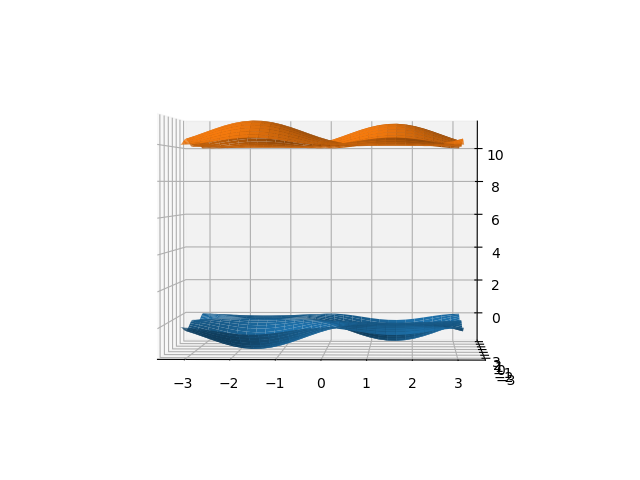

/tmp/ipykernel_18424/4186713472.py:37: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax1 = Axes3D(fig_bandstructure)


In [80]:
Band_1, Band_2 = Set_Spectrum_Bands_UC_1S_Fixed_Azimuth(Q,n,m)

path_1_kx = np.linspace(0.0, np.pi, number_of_steps, endpoint=True)
path_3_kx = np.linspace(np.pi, 0.0, number_of_steps, endpoint=True)
path_1 = np.ndarray((number_of_steps,2), dtype=float)
path_2 = np.ndarray((number_of_steps,2), dtype=float)
path_3 = np.ndarray((number_of_steps,2), dtype=float)

for ikx, kx in enumerate(path_1_kx):
    path_1[ikx][0] = kx
    path_1[ikx][1] = 0.0

for iky, ky in enumerate(path_1_kx):
    path_2[iky][0] = np.pi
    path_2[iky][1] = ky

for ikx, kx in enumerate(path_3_kx):
    path_3[ikx][0] = kx
    path_3[ikx][1] = kx
    
# bandstructure along paths 1, 2, and 3

bandstructure_path_1 = np.ndarray((number_of_steps,2), dtype=float)
bandstructure_path_2 = np.ndarray((number_of_steps,2), dtype=float)
bandstructure_path_3 = np.ndarray((number_of_steps,2), dtype=float)

for idk,k in enumerate(path_1):
    bandstructure_path_1[idk] = get_Bands_UC_1S_Fixed_Azimuth(k,Q,n,m)

for idk,k in enumerate(path_2):
    bandstructure_path_2[idk] = get_Bands_UC_1S_Fixed_Azimuth(k,Q,n,m)

for idk,k in enumerate(path_3):
    bandstructure_path_3[idk] = get_Bands_UC_1S_Fixed_Azimuth(k,Q,n,m)
    
fig_bandstructure = plt.figure()
ax1 = Axes3D(fig_bandstructure)
kx, ky = np.meshgrid(kx_grid, ky_grid)
surf = ax1.plot_surface(kx, ky, Band_1, rstride=1, cstride=1)
surf = ax1.plot_surface(kx, ky, Band_2, rstride=1, cstride=1)
plt.show()

<IPython.core.display.Javascript object>


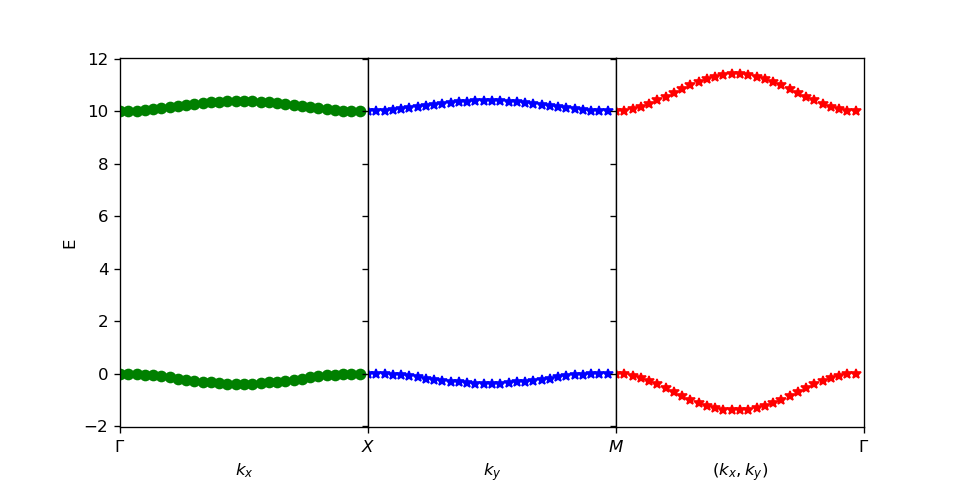

In [81]:
# Create Figure and Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4), sharey=True, dpi=120)
fig.subplots_adjust(wspace=0)


# Plot
ax1.plot(bandstructure_path_1, 'go')  # greendots
ax2.plot(bandstructure_path_2, 'b*')  # bluestart
ax3.plot(bandstructure_path_3, 'r*')  # bluestart

# Title, X and Y labels, X and Y Lim
#ax1.set_title('Scatterplot Greendots')
#ax2.set_title('Scatterplot Bluestars')
ax1.set_ylabel('E')
ax1.set_xlabel('$k_x$')
ax1.set_xlim(0,number_of_steps)
ax1.set_xticks([0.0,number_of_steps])
ax1.set_xticklabels(['$\Gamma$','$X$'])

ax2.set_xlabel('$k_y$')
ax2.set_xlim(0,number_of_steps)
ax2.set_xticks([number_of_steps])
ax2.set_xticklabels(['$M$'])

ax3.set_xlabel('$(k_x,k_y)$')
ax3.set_xlim(0,number_of_steps)
ax3.set_xticks([number_of_steps])
ax3.set_xticklabels(['$\Gamma$'])

plt.show()

### The Functional

\begin{equation}
\begin{split}
\Phi\left[\OP{\rho}_{\mathrm{eff}}\right] 
&= \frac{U}{N_{\mathrm{UC}}} \left(\sum_{\vectr{k}} X_{+,+} \left(\vectr{k}\right) \sum_{\vectr{k}'} X_{-,-} \left(\vectr{k}'\right)
    -\sum_{\vectr{k}} X_{+,-} \left(\vectr{k}\right) \sum_{\vectr{k}'} X_{-,+} \left(\vectr{k}'\right) \right)\\
%
&- \frac{U}{2} \varrho^{\phantom{\dagger}} \sum_{\xi} \sum_{\vectr{k}} X_{\xi,\xi} \left(\vectr{k}\right)\\
%
&+ U m^{z} \sum_{\vectr{k}} \left( X_{+,+} \left(\vectr{k}\right) - X_{-,-} \left(\vectr{k}\right)\right)\\
%
&- \frac{1}{\beta} \sum_{\vectr{k}} \sum_{l=1}^{2N_B} \ln{\left( 1 + \exp\left( -\beta \left(E_l\left(\vectr{k}\right) - \mu\right) \right) \right)}
\end{split}
\end{equation}

In [82]:
EV_Magnetisation_Fixed_Azimuth = 0.0
EV_Density_Fixed_Azimuth = 0.0

def Func_UC_1S_Fixed_Azimuth(Qx,Qy,n,m):
    global Hubbard_U
    global kx_grid
    global ky_grid
    global number_of_steps
    
    global effective_Hamiltonian_Fixed_Azimuth
    global full_Hamiltonian_Fixed_Azimuth
    global free_energy_Fixed_Azimuth
    
    sum_free_energy = 0.0
    interaction = 0.0 + 0.0j
    eff_interaction_charge = 0.0 + 0.0j
    eff_interaction_spin = 0.0 + 0.0j
    
    Fsum = 0.0
    sum_00 = 0.0
    sum_01 = 0.0
    sum_10 = 0.0
    sum_11 = 0.0
 
    for kx in kx_grid:
        for ky in ky_grid:
            w, v = la.eigh(Hamiltonian_UC_1S_Fixed_Azimuth(np.array([kx,ky]),np.array([Qx,Qy]),n,m))
            sum_00 += X(0,0, v, w)
            sum_01 += X(0,1, v, w)
            sum_10 += X(1,0, v, w)
            sum_11 += X(1,1, v, w)
            for vval in w:
                sum_free_energy += free_energy(vval)

    EV_Density_Fixed_Azimuth = np.real(sum_00+sum_11)/(number_of_steps*number_of_steps)
    EV_Magnetisation_Fixed_Azimuth = np.real(sum_00-sum_11)/(number_of_steps*number_of_steps)

    effective_Hamiltonian_Fixed_Azimuth  = (0.5*Hubbard_U*n*(sum_00+sum_11)\
                                                - Hubbard_U*m*(sum_00-sum_11))/np.power(number_of_steps,2)
    full_Hamiltonian_Fixed_Azimuth = Hubbard_U*(sum_00*sum_11-sum_01*sum_10)/np.power(number_of_steps,4)
    free_energy_Fixed_Azimuth = sum_free_energy/np.power(number_of_steps,2)
    
    Fsum = full_Hamiltonian_Fixed_Azimuth\
        - effective_Hamiltonian_Fixed_Azimuth\
        + free_energy_Fixed_Azimuth
    
    if np.iscomplex(Fsum):
        print("COMPLEX:")
        print(sum)

    return np.real(Fsum)

In [89]:
Temperatur = 0.0
Chemical_Potential = -2.0
Hubbard_U = 4.0

Qx = np.pi
Qy = np.pi

n_steps = 40
m_steps = 40

n_steps_arr = np.linspace(0.0, 2.0, n_steps, endpoint=True)
m_steps_arr = np.linspace(0.0, 0.5, m_steps, endpoint=True)

functional_mesh_Fixed_Azimuth = np.zeros(shape=(m_steps,n_steps))

f = FloatProgress(min=0, max=20)
display(f)

for idn, n in enumerate(n_steps_arr):
    for idm, m in enumerate(m_steps_arr):
        functional_mesh_Fixed_Azimuth[idm][idn] = Func_UC_1S_Fixed_Azimuth(Qx,Qy,n,m)
        #print(Func_UC_1S_Fixed_Azimuth(Qx,Qy,n,m))
    f.value += 1

np.save('functional_mesh_Fixed_Azimuth_CP_0200',functional_mesh_Fixed_Azimuth)

FloatProgress(value=0.0, max=20.0)

<IPython.core.display.Javascript object>


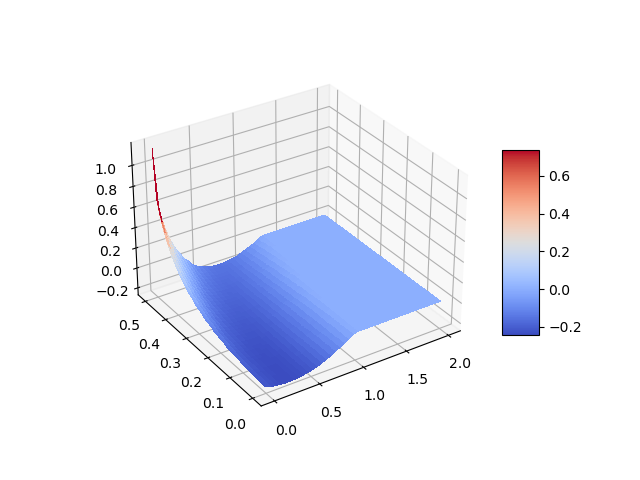

/tmp/ipykernel_18424/167735780.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [90]:
ngrid, mgrid = np.meshgrid(n_steps_arr, m_steps_arr)

functional = np.load('functional_mesh_Fixed_Azimuth_CP_0200.npy')

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(ngrid, mgrid, functional, rstride=1, cstride=1, 
                      cmap=cm.coolwarm,linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1500.0, -750.0)
#ax.set_ylim(-1.0, 1.0)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<IPython.core.display.Javascript object>


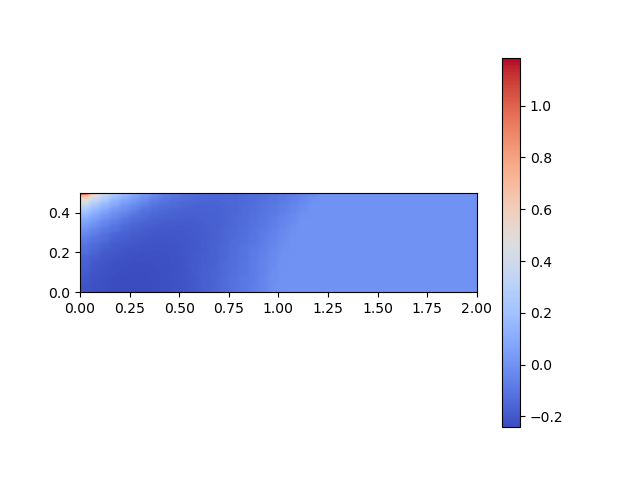

In [91]:
fig = plt.figure()
im = plt.imshow(functional_mesh_Fixed_Azimuth, origin='lower', extent=(0.0,2.0,0.0,0.5), cmap=cm.coolwarm) # drawing the function
#plt.xticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
#plt.yticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
# adding the Contour lines with labels
#cset = plt.contour(kx, ky, Band_1,np.arange(-4,4.0,1.0),linewidths=2,cmap=cm.Set2)
#plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#plt.colorbar(im) # adding the colobar on the right
plt.colorbar() # adding the colobar on the right
#plt.xticks([1,2])
# latex fashion title
plt.show()

## Conditional Wraps

### Antiferromagnetic Wrap

In [37]:
def MinFunc_Wrap_UC_1S_Fixed_Azimuth(x):
    n= x[0]
    m = x[1]*0.5*(1.0-np.fabs(1-x[0]))
    Qx = np.pi
    Qy = np.pi
    
    return Func_UC_1S_Fixed_Azimuth(Qx,Qy,n,m)

In [92]:
n_steps = 40
m_steps = 40

n_steps_arr = np.linspace(0.0, 2.0, n_steps, endpoint=True)
m_steps_arr = np.linspace(0.0, 1.0, m_steps, endpoint=True)

functional_mesh = np.zeros(shape=(m_steps,n_steps))

f = FloatProgress(min=0, max=n_steps)
display(f)

for idn, n in enumerate(n_steps_arr):
    for idm, m in enumerate(m_steps_arr):
        functional_mesh[idm][idn] = MinFunc_Wrap_UC_1S_Fixed_Azimuth(np.array([n,m]))
    f.value += 1

FloatProgress(value=0.0, max=40.0)

<IPython.core.display.Javascript object>


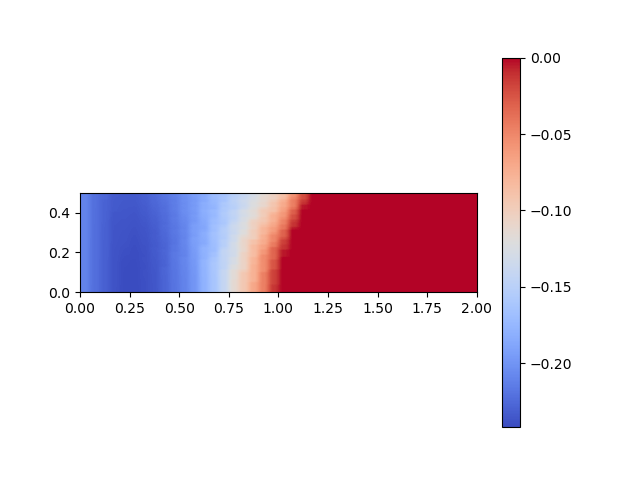

In [93]:
fig_functional_map = plt.figure()
im = plt.imshow(functional_mesh, extent=(0.0,2.0,0.0,0.5), origin='lower', cmap=cm.coolwarm) # drawing the function
#plt.xticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
#plt.yticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
# adding the Contour lines with labels
#cset = plt.contour(kx, ky, Band_1,np.arange(-4,4.0,1.0),linewidths=2,cmap=cm.Set2)
#plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#plt.colorbar(im) # adding the colobar on the right
plt.colorbar() # adding the colobar on the right
#plt.xticks([1,2])
# latex fashion title
plt.show()

<IPython.core.display.Javascript object>


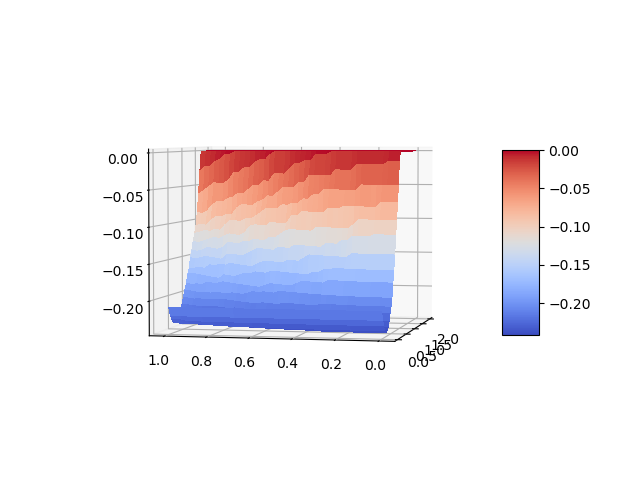

/tmp/ipykernel_18424/4236674751.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [94]:
ngrid, mgrid = np.meshgrid(n_steps_arr, m_steps_arr)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(ngrid, mgrid, functional_mesh, rstride=1, cstride=1, 
                      cmap=cm.coolwarm,linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1500.0, -750.0)
#ax.set_ylim(-1.0, 1.0)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### The Minimization

In [ ]:
Temperatur = 0.0
Chemical_Potential = 0.0
Hubbard_U = 10.0

In [ ]:
#bounds = [(0,2), (0.0, 1.0), (0.0,np.pi), (0.0,np.pi)]
bounds = [(0,2), (0.0, 1.0)]

In [ ]:
chem_pot_number_of_steps = 60
chem_pot_arr = np.linspace(-3.0, 3.0, chem_pot_number_of_steps, endpoint=True)

n_arr_afm = np.zeros(chem_pot_number_of_steps)
ev_n_arr_afm = np.zeros(chem_pot_number_of_steps)
m_arr_afm = np.zeros(chem_pot_number_of_steps)
ev_m_arr_afm = np.zeros(chem_pot_number_of_steps)
m_res_arr_afm = np.zeros(chem_pot_number_of_steps)
fct_arr_afm = np.zeros(chem_pot_number_of_steps)

# Create Figure and Subplots
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,10), dpi=120)

# Plot
ax1.set_ylabel('n')
ax1.set_xlabel('$\mu$')
ax1.plot(chem_pot_arr, n_arr_afm, 'go', label='n')

ax2.set_ylabel('m')
ax2.set_xlabel('$\mu$')
ax2.plot(chem_pot_arr, m_arr_afm, 'b*', label='m')
ax2.plot(chem_pot_arr, m_res_arr_afm, 'r-', label='m')

ax3.set_ylabel('E')
ax3.set_xlabel('$\mu$')
ax3.plot(chem_pot_arr, fct_arr_afm, 'r*', label='Free Energy')

plt.ion()

fig.show()
fig.canvas.draw()

chempotbar = FloatProgress(min=0, max=chem_pot_number_of_steps)
display(chempotbar)

#init_arr = np.array([[0.05,0.01],\
#                     [0.5,0.5],\
#                     [1.0,1.0],\
#                     [2.0,1.0],\
#                     [2.0,0.0]])
    
for idchem_pot, chem_pot in enumerate(chem_pot_arr):
    Chemical_Potential = chem_pot
    
    #result = shgo(MinFunc_Wrap_UC_1S_afm, bounds, n=100, iters=5)
    #result = shgo(MinFunc_Wrap, bounds)
    #result = shgo(MinFunc_Wrap_UC_1S_afm, bounds, iters=3)
    #result = dual_annealing(MinFunc_Wrap, bounds, maxiter=200)
    #result = differential_evolution(MinFunc_Wrap_UC_1S, bounds, maxiter=1000, updating='deferred', workers=-1)
    result = differential_evolution(MinFunc_Wrap_UC_1S_Blochparametrization,\
                                    bounds,\
                                    #init=init_arr,\
                                    #polish=False,\
                                    #disp=False,\
                                    #maxiter=50,\
                                    #updating='deferred',\
                                    workers=-1)
    
#    init_arr = np.array([[result.x[0],result.x[1]],\
#                         [0.05,0.01],\
#                         [0.5,0.5],\
#                         [1.0,1.0],\
#                         [2.0,1.0],\
#                         [2.0,0.0]])
    if result.success == True:
        n_arr_afm[idchem_pot] = result.x[0]
        ev_n_arr_afm[idchem_pot] = EV_Density_Blochparametrization
        m_arr_afm[idchem_pot] = result.x[1]
        ev_m_arr_afm[idchem_pot] = EV_Magnetisation_Blochparametrization
        m_res_arr_afm[idchem_pot] = result.x[1]*(1.0-np.fabs(1.0-result.x[0]))
        fct_arr_afm[idchem_pot] = result.fun
    else:
        print("no convergence.")

    chempotbar.value += 1
    
    ax1.clear()
    ax1.plot(chem_pot_arr, n_arr_afm, 'go', label='n')
    ax1.plot(chem_pot_arr, ev_n_arr_afm, 'b*', label='ev')
    ax2.clear()
    ax2.plot(chem_pot_arr, m_arr_afm, 'b*', label='m')
    ax2.plot(chem_pot_arr, ev_m_arr_afm, 'go', label='ev')
    ax2.plot(chem_pot_arr, m_res_arr_afm, 'r-', label='m_res')
    ax3.clear()
    ax3.plot(chem_pot_arr, fct_arr_afm, 'r*', label='Free Energy')
    fig.canvas.draw()

# Appendix

## Tetrahedron Integration

In [ ]:
def sort_n_track_ref_energy_2D( e_sort_A, e_sort_B, e_sort_C):
  # A, B, C
  if e_sort_A <= e_sort_B and e_sort_B <= e_sort_C:
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 1, e_sort_A, e_sort_B, e_sort_C

# A, C, B
  if e_sort_A <= e_sort_B and e_sort_A <= e_sort_C and e_sort_B >= e_sort_C:
    #swap(e_sort_B, e_sort_C)
    e_sort_B, e_sort_C = e_sort_C, e_sort_B
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 1, e_sort_A, e_sort_B, e_sort_C

# B, A, C
  if e_sort_A >= e_sort_B and e_sort_A <= e_sort_C and e_sort_B <= e_sort_C:
    #swap(e_sort_A, e_sort_B)
    e_sort_A, e_sort_B = e_sort_B, e_sort_A
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 2, e_sort_A, e_sort_B, e_sort_C

# B, C, A
  if e_sort_A >= e_sort_B and e_sort_A >= e_sort_C and e_sort_B <= e_sort_C:
    #swap(e_sort_A, e_sort_B)
    e_sort_A, e_sort_B = e_sort_B, e_sort_A
    #swap(e_sort_B, e_sort_C)
    e_sort_B, e_sort_C = e_sort_C, e_sort_B
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 3, e_sort_A, e_sort_B, e_sort_C

# C, A, B
  if e_sort_A <= e_sort_B and e_sort_A >= e_sort_C and e_sort_B >= e_sort_C:
    #swap(e_sort_B, e_sort_C)
    e_sort_B, e_sort_C = e_sort_C, e_sort_B
    #swap(e_sort_A, e_sort_B)
    e_sort_A, e_sort_B = e_sort_B, e_sort_A
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 2, e_sort_A, e_sort_B, e_sort_C

# C, B, A
  if e_sort_A >= e_sort_B and e_sort_A >= e_sort_C and e_sort_B >= e_sort_C:
    #swap(e_sort_A, e_sort_C)
    e_sort_A, e_sort_C = e_sort_C, e_sort_A
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 3, e_sort_A, e_sort_B, e_sort_C

  return -1

def tetrahedron_case_2_e_ref_position_1(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*3.0*D_E_A*D_E_A*D_B_A*D_C_A\
            - Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A*D_C_A\
            - Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A*D_B_A) / (3.0*Vol_full_BZ_2D*D_B_A*D_B_A*D_C_A*D_C_A))

def tetrahedron_case_2_e_ref_position_2(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A) / (3.0*Vol_full_BZ_2D*D_B_A*D_B_A*D_C_A))

def tetrahedron_case_2_e_ref_position_3(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A) / (3.0*Vol_full_BZ_2D*D_B_A*D_C_A*D_C_A))

def tetrahedron_case_3_e_ref_position_1(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*D_C_A*D_C_A*D_C_B\
            - Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E)/ (3.0*Vol_full_BZ_2D*D_C_A*D_C_A*D_C_B))

def tetrahedron_case_3_e_ref_position_2(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    #print("tetrahedron_case_3_e_ref_position_2")
    #print("D_C_A", D_C_A)
    #print("D_C_B", D_C_B)
    return((Vol_Tetrahedron_2D*D_C_B*D_C_B*D_C_A\
            - Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E) / (3.0*Vol_full_BZ_2D*D_C_A*D_C_B*D_C_B))

def tetrahedron_case_3_e_ref_position_3(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return(( Vol_Tetrahedron_2D*3.0*D_C_A*D_C_A*D_C_B*D_C_B - Vol_Tetrahedron_2D*D_C_E*D_C_A*D_C_B*D_C_B\
            - Vol_Tetrahedron_2D*D_C_E*D_C_B*D_C_A*D_C_A - Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_A*D_C_B\
            + Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E*D_C_B + Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E*D_C_A)\
            / (3.0*Vol_full_BZ_2D*D_C_A*D_C_A*D_C_B*D_C_B))

def integration_weight_switcher(tetrahedron_case, e_ref_position,\
                                D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                                Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    switcher_tetrahedron_case = {
        1: tetrahedron_case_1,
        2: tetrahedron_case_2,
        3: tetrahedron_case_3,
        4: tetrahedron_case_4
    }
    # Get the function from switcher dictionary
    e_ref_position_switcher = switcher_tetrahedron_case.get(tetrahedron_case, lambda: "Invalid Number")
    # Execute the function
    return e_ref_position_switcher(e_ref_position,\
                                   D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                                   Vol_Tetrahedron_2D, Vol_full_BZ_2D)

#Zero Contribution
def tetrahedron_case_1(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return (0.0)

def tetrahedron_case_2(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    switcher_tetrahedron_case_2_e_ref_position = {
        1: tetrahedron_case_2_e_ref_position_1,
        2: tetrahedron_case_2_e_ref_position_2,
        3: tetrahedron_case_2_e_ref_position_3
    }
    # Get the function from switcher dictionary
    integration_weigth = switcher_tetrahedron_case_2_e_ref_position.get(e_ref_position, lambda: "Invalid Number")
    # Execute the function
    return integration_weigth(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                              Vol_Tetrahedron_2D, Vol_full_BZ_2D)

def tetrahedron_case_3(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    switcher_tetrahedron_case_3_e_ref_position = {
        1: tetrahedron_case_3_e_ref_position_1,
        2: tetrahedron_case_3_e_ref_position_2,
        3: tetrahedron_case_3_e_ref_position_3
    }
    # Get the function from switcher dictionary
    integration_weigth = switcher_tetrahedron_case_3_e_ref_position.get(e_ref_position, lambda: "Invalid Number")
    # Execute the function
    return integration_weigth(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                              Vol_Tetrahedron_2D, Vol_full_BZ_2D)

#Full Contribution
def tetrahedron_case_4(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return (Vol_Tetrahedron_2D / (3.0*Vol_full_BZ_2D))

def Integration_weigth_2D(Chemical_Potential, E_ref_in, E_B_in, E_C_in, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    #sort e_sort_A, e_sort_B, e_sort_C, so that e_sort_A <= e_sort_B <= e_sort_C
    #http://stackoverflow.com/questions/6145364/sort-4-number-with-few-comparisons
    
    integrationweight = 0.0
    e_ref_position_tracker = -1
    tetrahedron_case_switch = -1

    e_ref_position_tracker, E_ref, E_B, E_C = sort_n_track_ref_energy_2D(E_ref_in, E_B_in, E_C_in)
    
    #print("Integration_weigth_2D", E_ref, E_B, E_C, "\n")
        
    if Chemical_Potential < E_ref:
        tetrahedron_case_switch = 1
    if E_ref <= Chemical_Potential and Chemical_Potential <= E_B:  
        tetrahedron_case_switch = 2
    if E_B < Chemical_Potential and Chemical_Potential <= E_C:
        tetrahedron_case_switch = 3
    if E_C < Chemical_Potential:
        tetrahedron_case_switch = 4

    D_E_A = Chemical_Potential - E_ref
    D_B_A = E_B - E_ref
    D_C_A = E_C - E_ref
    D_C_E = E_C - Chemical_Potential
    D_C_B = E_C - E_B

    if (np.fabs(D_B_A) <= 1e-8 or np.fabs(D_C_A) <= 1e-8 or np.fabs(D_C_B) <= 1e-8) and np.fabs(D_E_A) <= 1e-8:
        integrationweight = 0.0
    elif (np.fabs(D_B_A) <= 1e-8 or np.fabs(D_C_A) <= 1e-8 or np.fabs(D_C_B) <= 1e-8) and np.fabs(D_C_E) <= 1e-8:
        integrationweight = Vol_Tetrahedron_2D / (3.0*Vol_full_BZ_2D)
    else:
        integrationweight = integration_weight_switcher(tetrahedron_case_switch, e_ref_position_tracker,\
                                                        D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                                                        Vol_Tetrahedron_2D, Vol_full_BZ_2D)
    return(integrationweight*3.0/2.0)

def GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_array):
    
    Vol_full_BZ_2D = 4.0*np.pi*np.pi
    Vol_Tetrahedron_2D = 4.0*np.pi*np.pi/((number_of_steps-1)*(number_of_steps-1))
    
    integration_weigths_arr = np.zeros(shape=Band_array.shape)

    #bulk_kx_grid = np.delete(kx_grid,0,0)
    bulk_kx_grid = np.delete(kx_grid,[0,number_of_steps-1],0)
    #bulk_ky_grid = np.delete(ky_grid,0,0)
    bulk_ky_grid = np.delete(ky_grid,[0,number_of_steps-1],0)
    
    #Bulk
    for iky,ky in enumerate(bulk_ky_grid):
        for ikx,kx in enumerate(bulk_kx_grid):
            E_ref = Band_array[iky+1][ikx+1]
            E_1 = Band_array[iky+1][ikx+2]
            E_2 = Band_array[iky+2][ikx+1]
            E_3 = Band_array[iky+1][ikx]
            E_4 = Band_array[iky][ikx+1]

            #Tetrahedron 1
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_1, E_2,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)

            #Tetrahedron 2
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_2, E_3,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)

            #Tetrahedron 3
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_3, E_4,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)
                
            #Tetrahedron 4
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_4, E_1,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)
    
    #ky = -np.pi line
    iky = 0
    for ikx, kx in enumerate(bulk_kx_grid):
        E_ref = Band_array[iky][ikx+1]
        E_1 = Band_array[iky][ikx+2]
        E_2 = Band_array[iky+1][ikx+1]
        E_3 = Band_array[iky][ikx]
        E_4 = Band_array[iky+number_of_steps-1][ikx+1]

        #Tetrahedron 1
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_1, E_2,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 2
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_2, E_3,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 3
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_3, E_4,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 4
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_4, E_1,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #kx = -np.pi line
    ikx = 0
    for iky, ky in enumerate(bulk_ky_grid):
        E_ref = Band_array[iky+1][ikx]
        E_1 = Band_array[iky+1][ikx+1]
        E_2 = Band_array[iky+2][ikx]
        E_3 = Band_array[iky+1][ikx+number_of_steps-1]
        E_4 = Band_array[iky][ikx]

        #Tetrahedron 1
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_1, E_2,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 2
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_2, E_3,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 3
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_3, E_4,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 4
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_4, E_1,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    ## Corners
    
    #ikx = 0
    #kx = -np.pi
    #iky = 0
    #ky = -np.pi
    E_ref = Band_array[0][0]
    E_1 = Band_array[0][1]
    E_2 = Band_array[1][0]
    E_3 = Band_array[0][number_of_steps-1]
    E_4 = Band_array[number_of_steps-1][0]

    #Tetrahedron 1
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_1, E_2,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #Tetrahedron 2
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_2, E_3,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #Tetrahedron 3
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_3, E_4,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #Tetrahedron 4
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_4, E_1,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)
    
    return integration_weigths_arr

In [ ]:
def Func_UC_1S_Blochparametrization(n,m,theta,qx,qy):
    global Hubbard_U
    global number_of_steps
    global Chemical_Potential
    global kx_grid
    global ky_grid
    
    Temperatur = 0.0

    sum = 0.0 + 0.0j
    sum_00 = 0.0 + 0.0j
    sum_01 = 0.0 + 0.0j
    sum_10 = 0.0 + 0.0j
    sum_11 = 0.0 + 0.0j
    sum_free_energy = 0.0
    
    Band_1, Band_1_evec, Band_2, Band_2_evec = Set_Spectrum_Bands_UC_1S_evecs(np.array([qx,qy]),n,m,theta)
    
    intw_arr_1 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_1)
    intw_arr_2 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_2)

    sum_kx_grid = np.delete(kx_grid,0,0)
    sum_ky_grid = np.delete(ky_grid,0,0)

    for ikx, kx in enumerate(sum_kx_grid):
        for iky, ky in enumerate(sum_ky_grid):
            sum_00 += np.conj(Band_1_evec[iky][ikx][0])*Band_1_evec[iky][ikx][0]*intw_arr_1[iky][ikx]
            sum_00 += np.conj(Band_2_evec[iky][ikx][0])*Band_2_evec[iky][ikx][0]*intw_arr_2[iky][ikx]
            
            sum_01 += np.conj(Band_1_evec[iky][ikx][0])*Band_1_evec[iky][ikx][1]*intw_arr_1[iky][ikx]
            sum_01 += np.conj(Band_2_evec[iky][ikx][0])*Band_2_evec[iky][ikx][1]*intw_arr_2[iky][ikx]
            
            sum_10 += np.conj(Band_1_evec[iky][ikx][1])*Band_1_evec[iky][ikx][0]*intw_arr_1[iky][ikx]
            sum_10 += np.conj(Band_2_evec[iky][ikx][1])*Band_2_evec[iky][ikx][0]*intw_arr_2[iky][ikx]
            
            sum_11 += np.conj(Band_1_evec[iky][ikx][1])*Band_1_evec[iky][ikx][1]*intw_arr_1[iky][ikx]
            sum_11 += np.conj(Band_2_evec[iky][ikx][1])*Band_2_evec[iky][ikx][1]*intw_arr_2[iky][ikx]
            
            sum_free_energy += free_energy(Band_1[iky][ikx], Temperatur, Chemical_Potential)
            sum_free_energy += free_energy(Band_2[iky][ikx], Temperatur, Chemical_Potential)

    sum = - 0.5*Hubbard_U*n*(sum_00+sum_11)\
        - (Hubbard_U*sum_01*sum_10)\
        + (Hubbard_U*sum_00*sum_11)\
        + sum_free_energy/(number_of_steps*number_of_steps)\
        + 0.5*Hubbard_U*m*np.sin(theta)*(sum_01+sum_10)\
        + 0.5*Hubbard_U*m*np.cos(theta)*(sum_00-sum_11)

    if np.iscomplex(sum):
        print("COMPLEX:")
        print(sum)
    
    return(np.real(sum))

In [ ]:
Hubbard_U = 10.0

chem_pot_number_of_steps = 50
chem_pot_arr = np.linspace(-3.8, 14.0, chem_pot_number_of_steps, endpoint=True)

n_arr = np.zeros(chem_pot_number_of_steps)
m_arr = np.zeros(chem_pot_number_of_steps)
m_res_arr = np.zeros(chem_pot_number_of_steps)
theta_arr = np.zeros(chem_pot_number_of_steps)
qx_arr = np.zeros(chem_pot_number_of_steps)
qy_arr = np.zeros(chem_pot_number_of_steps)
fct_arr = np.zeros(chem_pot_number_of_steps)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, dpi=120)

ax1.set_ylabel('n')
ax1.set_xlabel('$\mu$')
ax2.set_ylabel('m')
ax2.set_xlabel('$\mu$')
ax3.set_ylabel('angle')
ax3.set_xlabel('$\mu$')
ax3.legend(loc='upper right')
ax4.set_ylabel('E')
ax4.set_xlabel('$\mu$')

plt.ion()

fig.show()
fig.canvas.draw()

chempotbar = FloatProgress(min=0, max=chem_pot_number_of_steps)
display(chempotbar)

#minimizer_kwargs = {"method":"L-BFGS-B"}
#x0 = [0.0, 0.0, 0.0, 0.0]
init_arr = np.array([[0.05,0.01,np.pi,np.pi],\
                     [0.05,0.005,np.pi,np.pi],\
                     [0.05,0.01,0.0,np.pi],\
                     [0.05,0.01,np.pi,0.0],\
                     [0.05,0.01,0.0,0.0]])
    
for idchem_pot, chem_pot in enumerate(chem_pot_arr):
    Chemical_Potential = chem_pot
        
    #result = shgo(MinFunc_Wrap, bounds)
    #result = shgo(MinFunc_Wrap_UC_1S, bounds, iters=3)
    #result = dual_annealing(MinFunc_Wrap, bounds, maxiter=200)
    #result = differential_evolution(MinFunc_Wrap_UC_1S, bounds, maxiter=1000, updating='deferred', workers=-1)
    result = differential_evolution(MinFunc_Wrap_UC_1S,\
                                    bounds,\
                                    #init=init_arr,\
                                    polish=False,\
                                    disp=False,\
                                    maxiter=1000,\
                                    updating='deferred',\
                                    workers=-1)
    
    init_arr = np.array([[result.x[0],result.x[1],np.pi,np.pi],\
                         [result.x[0],0.5*result.x[1],np.pi,np.pi],\
                         [result.x[0],result.x[1],0.0,np.pi],\
                         [result.x[0],result.x[1],np.pi,0.0],\
                         [result.x[0],result.x[1],0.0,0.0],\
                         #[result.x[0],result.x[1],result.x[2],result.x[3]],
                         [0.05,0.01,np.pi,np.pi],\
                         [0.05,0.005,np.pi,np.pi],\
                         [0.05,0.01,0.0,np.pi],\
                         [0.05,0.01,np.pi,0.0],\
                         [0.05,0.01,0.0,0.0],\
                         [1.0,1.0,np.pi,np.pi],\
                         [1.0,0.5,np.pi,np.pi],\
                         [1.0,1.0,0.0,np.pi],\
                         [1.0,1.0,np.pi,0.0],\
                         [1.0,1.0,0.0,0.0],\
                         [2.0,1.0,np.pi,np.pi],\
                         [2.0,0.5,np.pi,np.pi],\
                         [2.0,1.0,0.0,np.pi],\
                         [2.0,1.0,np.pi,0.0],\
                         [2.0,1.0,0.0,0.0]])

    n_arr[idchem_pot] = result.x[0]
    m_arr[idchem_pot] = result.x[1]
    m_res_arr[idchem_pot] = result.x[1]*(1.0-np.fabs(1-result.x[0]))
    #qx_arr[idchem_pot] = result.x[2]
    #qy_arr[idchem_pot] = result.x[3]
    fct_arr[idchem_pot] = result.fun
    chempotbar.value += 1
    
    ax1.clear()
    ax1.plot(chem_pot_arr, n_arr, 'go', label='n')
    ax2.clear()
    ax2.plot(chem_pot_arr, m_arr, 'b*', label='m')
    ax2.plot(chem_pot_arr, m_res_arr, 'r-', label='m')
    ax3.clear()
    ax3.plot(chem_pot_arr, theta_arr, 'r*', label='theta')
    ax3.plot(chem_pot_arr, qx_arr, 'bo', label='qx')
    ax3.plot(chem_pot_arr, qy_arr, 'g.', label='qx')
    ax4.clear()
    ax4.plot(chem_pot_arr, fct_arr, 'r*', label='Free Energy')
    fig.canvas.draw()

In [ ]:
# Create Figure and Subplots
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8,20), dpi=120)
#fig.subplots_adjust(wspace=0)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, dpi=120)

# Plot
ax1.set_ylabel('n')
ax1.set_xlabel('$\mu$')
ax1.plot(chem_pot_arr, n_arr, 'go', label='n')

ax2.set_ylabel('m')
ax2.set_xlabel('$\mu$')
ax2.plot(chem_pot_arr, m_arr, 'b*', label='m')
ax2.plot(chem_pot_arr, m_res_arr, 'r-', label='m')

ax3.set_ylabel('angle')
ax3.set_xlabel('$\mu$')
ax3.plot(chem_pot_arr, theta_arr, 'r*', label='theta')
ax3.plot(chem_pot_arr, qx_arr, 'bo', label='qx')
ax3.plot(chem_pot_arr, qy_arr, 'g.', label='qx')
# Modify legend
ax3.legend(loc='upper right')
#plt.legend([sine[0], cosine[0], sine_2[0], cosine_2[0]],   # plot items
#           ['sine curve', 'cosine curve', 'sine curve 2', 'cosine curve 2'],  
#           frameon=True,                                   # legend border
#           framealpha=1,                                   # transparency of border
#           ncol=2,                                         # num columns
#           shadow=True,                                    # shadow on
#           borderpad=1,                                    # thickness of border
#           title='Sines and Cosines')                      # title

ax4.set_ylabel('E')
ax4.set_xlabel('$\mu$')
ax4.plot(chem_pot_arr, fct_arr, 'r*', label='Free Energy')

#ax1.set_title('Scatterplot Greendots')
#ax2.set_title('Scatterplot Bluestars')

plt.show()